In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("开始数据质量检查...")
print("="*80 + "\n")

# 1. 读取原始数据
print("1. 读取原始数据")
print("-"*40)

df_stats = pd.read_csv('world_country_stats.csv')
df_pop_2023 = pd.read_csv('world_population_by_country_2023.csv')
df_time_series = pd.read_csv('world_population_by_year_1950_2023.csv')

print(f"世界国家统计数据 - 形状: {df_stats.shape}")
print(f"2023年人口数据 - 形状: {df_pop_2023.shape}")
print(f"时间序列数据 - 形状: {df_time_series.shape}")

# 2. 基础清洗函数（仅处理列名和空格）
def basic_clean_for_check(df, df_name):
    """基础清洗用于检查，只处理列名和空格"""
    df_clean = df.copy()
    
    # 去除列名中的空格和特殊字符
    df_clean.columns = df_clean.columns.str.strip()
    
    # 处理可能的BOM字符
    for col in df_clean.columns:
        if col.startswith('﻿'):  # 检查BOM字符
            new_col = col.replace('﻿', '')
            df_clean = df_clean.rename(columns={col: new_col})
            print(f"  {df_name}: 修复列名 '{col}' -> '{new_col}'")
    
    # 去除字符串列的前后空格
    for col in df_clean.select_dtypes(include=['object']).columns:
        df_clean[col] = df_clean[col].astype(str).str.strip()
    
    return df_clean

# 应用基础清洗
print("\n2. 应用基础清洗")
print("-"*40)

df_stats_clean = basic_clean_for_check(df_stats, "世界国家统计数据")
df_pop_2023_clean = basic_clean_for_check(df_pop_2023, "2023年人口数据")
df_time_series_clean = basic_clean_for_check(df_time_series, "时间序列数据")

# 3. 检查重复行
print("\n3. 检查重复行")
print("-"*40)

def check_duplicates(df, df_name):
    """检查并展示重复行信息"""
    print(f"{df_name}:")
    
    # 检查完全重复的行
    full_duplicates = df.duplicated().sum()
    if full_duplicates > 0:
        print(f"  完全重复的行数: {full_duplicates}")
        print("  重复行示例:")
        duplicates = df[df.duplicated(keep=False)]
        print(duplicates.head())
    else:
        print("  没有完全重复的行")
    
    # 如果存在country列，检查国家名称重复
    if 'country' in df.columns:
        country_duplicates = df['country'].duplicated().sum()
        if country_duplicates > 0:
            print(f"  重复的国家名称数量: {country_duplicates}")
            dup_countries = df[df['country'].duplicated(keep=False)]['country'].unique()
            print(f"  重复的国家: {list(dup_countries)[:10]}")
        else:
            print("  国家名称无重复")
    
    print()

# 检查各数据集的重复情况
check_duplicates(df_stats_clean, "世界国家统计数据")
check_duplicates(df_pop_2023_clean, "2023年人口数据")
check_duplicates(df_time_series_clean, "时间序列数据")

# 4. 检查缺失值
print("\n4. 检查缺失值")
print("-"*40)

def check_missing_values(df, df_name):
    """检查缺失值情况"""
    print(f"{df_name}:")
    
    # 计算各列缺失值
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    
    # 只显示有缺失值的列
    missing_data = pd.DataFrame({
        '缺失值数量': missing_counts,
        '缺失值比例%': missing_percent.round(2)
    })
    
    missing_data = missing_data[missing_data['缺失值数量'] > 0]
    
    if len(missing_data) > 0:
        print(f"  有缺失值的列数: {len(missing_data)}")
        print(missing_data)
        
        # 如果有country列，显示有缺失值的国家
        if 'country' in df.columns:
            missing_countries = {}
            for col in missing_data.index:
                if col != 'country':
                    countries_with_missing = df[df[col].isnull()]['country'].tolist()
                    if countries_with_missing:
                        missing_countries[col] = countries_with_missing
            
            if missing_countries:
                print("\n  有缺失值的国家:")
                for col, countries in missing_countries.items():
                    print(f"    {col}: {countries}")
    else:
        print("  没有缺失值")
    
    print()

# 检查各数据集的缺失值
check_missing_values(df_stats_clean, "世界国家统计数据")
check_missing_values(df_pop_2023_clean, "2023年人口数据")
check_missing_values(df_time_series_clean, "时间序列数据")


# 5. 数据基本统计
print("\n5. 数据基本统计信息")
print("-"*40)

def basic_statistics(df, df_name):
    """显示数据基本统计信息"""
    print(f"{df_name}:")
    
    print(f"  行数: {len(df)}")
    print(f"  列数: {len(df.columns)}")
    
    # 显示列名
    print(f"  列名: {list(df.columns)[:10]}")  # 只显示前10个列
    if len(df.columns) > 10:
        print(f"    ... 还有 {len(df.columns)-10} 个列")
    
    # 数值列的基本统计
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"  数值列: {list(numeric_cols)[:5]}")  # 只显示前5个数值列
        if len(numeric_cols) > 5:
            print(f"    ... 还有 {len(numeric_cols)-5} 个数值列")
    else:
        print("  没有数值列")
    
    print()

# 显示各数据集的基本统计
basic_statistics(df_stats_clean, "世界国家统计数据")
basic_statistics(df_pop_2023_clean, "2023年人口数据")
basic_statistics(df_time_series_clean, "时间序列数据")

# 6. 检查数据集间的一致性
print("\n6. 检查三个数据集间的一致性")
print("-"*40)

# 获取各数据集的国家列表
countries_stats = set(df_stats_clean['country'].unique())
countries_pop = set(df_pop_2023_clean['country'].unique())
countries_ts = set(df_time_series_clean['country'].unique())

print(f"世界国家统计数据中的国家数量: {len(countries_stats)}")
print(f"2023年人口数据中的国家数量: {len(countries_pop)}")
print(f"时间序列数据中的国家数量: {len(countries_ts)}")

# 检查交集
intersection_all = countries_stats & countries_pop & countries_ts
print(f"\n三个数据集都有的国家数量: {len(intersection_all)}")

# 检查只在某个数据集中出现的国家
only_in_stats = countries_stats - countries_pop - countries_ts
only_in_pop = countries_pop - countries_stats - countries_ts
only_in_ts = countries_ts - countries_stats - countries_pop

print(f"\n只在世界国家统计数据中的国家: {len(only_in_stats)}")
if only_in_stats:
    print(f"  示例: {sorted(list(only_in_stats))[:5]}")

print(f"\n只在2023年人口数据中的国家: {len(only_in_pop)}")
if only_in_pop:
    print(f"  示例: {sorted(list(only_in_pop))[:5]}")

print(f"\n只在时间序列数据中的国家: {len(only_in_ts)}")
if only_in_ts:
    print(f"  示例: {sorted(list(only_in_ts))[:5]}")

# 7. 特殊检查：时间序列数据的列结构
print("\n7. 时间序列数据的年份列检查")
print("-"*40)

# 找出所有年份列
year_cols = [col for col in df_time_series_clean.columns if col.isdigit()]
print(f"年份列数量: {len(year_cols)}")
print(f"时间范围: {min(year_cols)} - {max(year_cols)}")

# 检查年份列是否连续
year_nums = sorted([int(col) for col in year_cols])
expected_years = list(range(min(year_nums), max(year_nums) + 1))
missing_years = [year for year in expected_years if str(year) not in year_cols]

if missing_years:
    print(f"警告: 缺少以下年份: {missing_years}")
else:
    print("年份列是连续的")

# 8. 保存清洗后的数据（不填充缺失值）
print("\n8. 保存清洗后的数据")
print("-"*40)

# 去除重复行（基于所有列）
df_stats_final = df_stats_clean.drop_duplicates()
df_pop_2023_final = df_pop_2023_clean.drop_duplicates()
df_time_series_final = df_time_series_clean.drop_duplicates()

print(f"去重后 - 世界国家统计数据: {df_stats_final.shape}")
print(f"去重后 - 2023年人口数据: {df_pop_2023_final.shape}")
print(f"去重后 - 时间序列数据: {df_time_series_final.shape}")

# 保存数据
df_stats_final.to_csv('world_country_stats_checked.csv', index=False)
df_pop_2023_final.to_csv('world_population_2023_checked.csv', index=False)
df_time_series_final.to_csv('world_population_timeseries_checked.csv', index=False)

print("\n已保存清洗后的数据:")
print("1. world_country_stats_checked.csv")
print("2. world_population_2023_checked.csv")
print("3. world_population_timeseries_checked.csv")

# 9. 生成数据质量报告
print("\n" + "="*80)
print("9. 数据质量报告摘要")
print("="*80)

print("A. 数据完整性:")
print(f"   1. 世界国家统计数据:")
print(f"      - 总行数: {len(df_stats_final)}")
print(f"      - 缺失值总数: {df_stats_final.isnull().sum().sum()}")
print(f"      - 数据完整度: {(1 - df_stats_final.isnull().sum().sum() / (len(df_stats_final) * len(df_stats_final.columns))) * 100:.1f}%")

print(f"\n   2. 2023年人口数据:")
print(f"      - 总行数: {len(df_pop_2023_final)}")
print(f"      - 缺失值总数: {df_pop_2023_final.isnull().sum().sum()}")
print(f"      - 数据完整度: {(1 - df_pop_2023_final.isnull().sum().sum() / (len(df_pop_2023_final) * len(df_pop_2023_final.columns))) * 100:.1f}%")

print(f"\n   3. 时间序列数据:")
print(f"      - 总行数: {len(df_time_series_final)}")
print(f"      - 缺失值总数: {df_time_series_final.isnull().sum().sum()}")
print(f"      - 数据完整度: {(1 - df_time_series_final.isnull().sum().sum() / (len(df_time_series_final) * len(df_time_series_final.columns))) * 100:.1f}%")

print("\nB. 重复数据情况:")
print(f"   世界国家统计数据: {len(df_stats_clean) - len(df_stats_final)} 行重复")
print(f"   2023年人口数据: {len(df_pop_2023_clean) - len(df_pop_2023_final)} 行重复")
print(f"   时间序列数据: {len(df_time_series_clean) - len(df_time_series_final)} 行重复")


print("\nC. 数据集一致性:")
print(f"   三个数据集共有的国家数: {len(intersection_all)}")

print("\n" + "="*80)
print("数据质量检查完成！")

开始数据质量检查...

1. 读取原始数据
----------------------------------------
世界国家统计数据 - 形状: (234, 5)
2023年人口数据 - 形状: (234, 11)
时间序列数据 - 形状: (234, 75)

2. 应用基础清洗
----------------------------------------

3. 检查重复行
----------------------------------------
世界国家统计数据:
  没有完全重复的行
  国家名称无重复

2023年人口数据:
  没有完全重复的行
  国家名称无重复

时间序列数据:
  没有完全重复的行
  国家名称无重复


4. 检查缺失值
----------------------------------------
世界国家统计数据:
  有缺失值的列数: 2
                缺失值数量  缺失值比例%
fertility_rate      1    0.43
median_age          1    0.43

  有缺失值的国家:
    fertility_rate: ['Holy See']
    median_age: ['Holy See']

2023年人口数据:
  有缺失值的列数: 3
                  缺失值数量  缺失值比例%
fertility_rate        1    0.43
median_age            1    0.43
population_urban     18    7.69

  有缺失值的国家:
    fertility_rate: ['Holy See']
    median_age: ['Holy See']
    population_urban: ['American Samoa', 'Bahrain', 'Gibraltar', 'Guadeloupe', 'Holy See', 'Hong Kong', 'Kuwait', 'Marshall Islands', 'Monaco', 'Northern Mariana Islands', 'Oman', 'Palau', 'Puerto Ric

In [2]:
print("开始处理数据缺失值问题...")
print("="*80 + "\n")

# 读取清洗后的数据
df_stats = pd.read_csv('world_country_stats_checked.csv')
df_pop = pd.read_csv('world_population_2023_checked.csv')
df_ts = pd.read_csv('world_population_timeseries_checked.csv')

print("1. 处理梵蒂冈(Holy See)的缺失值")
print("-"*40)

# 策略：使用相似国家数据填充梵蒂冈的缺失值
print("\n2. 选择相似国家作为参考")
print("-"*40)

# 定义相似国家（欧洲的小国家/城国家）
similar_countries = ['Monaco', 'San Marino', 'Liechtenstein', 'Andorra']
similar_data = df_stats[df_stats['country'].isin(similar_countries)]

print("相似国家数据:")
print(similar_data[['country', 'region', 'fertility_rate', 'median_age']])

# 计算相似国家的平均值
avg_fertility = similar_data['fertility_rate'].mean()
avg_median_age = similar_data['median_age'].mean()

print(f"\n相似国家的平均值:")
print(f"  生育率: {avg_fertility:.2f}")
print(f"  中位年龄: {avg_median_age:.1f}")

print("\n3. 填充缺失值")
print("-"*40)

# 填充世界国家统计数据中的缺失值
df_stats_filled = df_stats.copy()

# 查找需要填充的行（梵蒂冈）
holy_see_idx = df_stats_filled[df_stats_filled['country'] == 'Holy See'].index

if len(holy_see_idx) > 0:
    # 填充生育率
    df_stats_filled.loc[holy_see_idx, 'fertility_rate'] = avg_fertility
    
    # 填充中位年龄
    df_stats_filled.loc[holy_see_idx, 'median_age'] = avg_median_age
    
    print("已填充世界国家统计数据中的缺失值:")
    print(f"  梵蒂冈的生育率填充为: {avg_fertility:.2f}")
    print(f"  梵蒂冈的中位年龄填充为: {avg_median_age:.1f}")
else:
    print("未找到梵蒂冈记录")

# 填充2023年人口数据中的缺失值
df_pop_filled = df_pop.copy()

# 填充梵蒂冈的生育率和中位年龄
holy_see_pop_idx = df_pop_filled[df_pop_filled['country'] == 'Holy See'].index

if len(holy_see_pop_idx) > 0:
    df_pop_filled.loc[holy_see_pop_idx, 'fertility_rate'] = avg_fertility
    df_pop_filled.loc[holy_see_pop_idx, 'median_age'] = avg_median_age
    print("\n已填充2023年人口数据中梵蒂冈的缺失值")

print("\n4. 处理城市人口比例(population_urban)缺失值")
print("-"*40)

# 首先，从世界国家统计数据中获取地区信息
# 将地区信息合并到人口数据中
df_pop_with_region = pd.merge(
    df_pop_filled,
    df_stats_filled[['country', 'region']],
    on='country',
    how='left'
)

print(f"合并地区信息后，数据形状: {df_pop_with_region.shape}")

# 查看哪些地区缺失城市人口比例数据
missing_urban = df_pop_with_region[df_pop_with_region['population_urban'].isnull()]
print(f"有 {len(missing_urban)} 个国家/地区缺少城市人口比例数据")

# 按地区分组，计算各地区的平均城市人口比例
region_urban_means = df_pop_with_region.groupby('region')['population_urban'].mean()

print("\n各地区的平均城市人口比例:")
for region, mean_value in region_urban_means.items():
    print(f"  {region}: {mean_value:.1f}%")

# 用地区平均值填充缺失的城市人口比例
for region in df_pop_with_region['region'].unique():
    region_mask = (df_pop_with_region['region'] == region) & (df_pop_with_region['population_urban'].isnull())
    if region_mask.any():
        fill_value = region_urban_means[region]
        df_pop_with_region.loc[region_mask, 'population_urban'] = fill_value
        count = region_mask.sum()
        print(f"  为{region}地区的{count}个国家填充了城市人口比例: {fill_value:.1f}%")

# 更新df_pop_filled
df_pop_filled = df_pop_with_region.drop(columns=['region'])

print("\n5. 创建统一的数据集（直接使用2023年数据）")
print("-"*40)

# 创建统一数据集，使用2023年数据作为主要数据源
# 只从世界国家统计数据中提取地区信息，其他数据都使用2023年数据
df_unified = pd.merge(
    df_stats_filled[['country', 'region']],  # 只保留国家名称和地区信息
    df_pop_filled.drop(columns=['region'] if 'region' in df_pop_filled.columns else []),
    on='country',
    how='left'
)

print(f"统一数据集形状: {df_unified.shape}")

# 检查关键列
print("\n数据集包含的列:")
for i, col in enumerate(df_unified.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n6. 保存处理后的数据")
print("-"*40)

# 保存处理后的数据
df_stats_filled.to_csv('world_country_stats_filled.csv', index=False)
df_pop_filled.to_csv('world_population_2023_filled.csv', index=False)
df_unified.to_csv('world_data_unified_final.csv', index=False)

print("已保存处理后的数据:")
print("1. world_country_stats_filled.csv - 填充后的世界国家统计数据")
print("2. world_population_2023_filled.csv - 填充后的2023年人口数据")
print("3. world_data_unified_final.csv - 统一的数据集")

print("\n7. 数据质量报告")
print("-"*40)

# 检查最终数据的缺失值
final_missing = df_unified.isnull().sum().sum()
print(f"最终数据集 - 总缺失值: {final_missing}")

if final_missing > 0:
    print("\n仍有缺失值的列:")
    missing_cols = df_unified.columns[df_unified.isnull().any()].tolist()
    for col in missing_cols:
        missing_count = df_unified[col].isnull().sum()
        print(f"  {col}: {missing_count} 个缺失值")
else:
    print("\n所有缺失值已处理完成！")

# 显示数据集基本信息
print("\n数据集基本信息:")
print(f"  国家数量: {df_unified['country'].nunique()}")
print(f"  地区数量: {df_unified['region'].nunique()}")
print(f"  总人口: {df_unified['population'].sum():,.0f}")

# 显示一些关键指标的统计
print("\n关键统计指标:")

if 'fertility_rate' in df_unified.columns:
    fertility_stats = df_unified['fertility_rate'].describe()
    print(f"\n生育率统计:")
    print(f"  平均值: {fertility_stats['mean']:.2f}")
    print(f"  中位数: {fertility_stats['50%']:.2f}")
    print(f"  最小值: {fertility_stats['min']:.2f} (国家: {df_unified.loc[df_unified['fertility_rate'].idxmin(), 'country']})")
    print(f"  最大值: {fertility_stats['max']:.2f} (国家: {df_unified.loc[df_unified['fertility_rate'].idxmax(), 'country']})")

if 'median_age' in df_unified.columns:
    age_stats = df_unified['median_age'].describe()
    print(f"\n中位年龄统计:")
    print(f"  平均值: {age_stats['mean']:.1f}")
    print(f"  中位数: {age_stats['50%']:.1f}")
    print(f"  最小值: {age_stats['min']:.0f} (国家: {df_unified.loc[df_unified['median_age'].idxmin(), 'country']})")
    print(f"  最大值: {age_stats['max']:.0f} (国家: {df_unified.loc[df_unified['median_age'].idxmax(), 'country']})")

if 'population' in df_unified.columns:
    pop_stats = df_unified['population'].describe()
    print(f"\n人口统计:")
    print(f"  总人口: {df_unified['population'].sum():,.0f}")
    print(f"  平均值: {pop_stats['mean']:,.0f}")
    print(f"  中位数: {pop_stats['50%']:,.0f}")
    print(f"  最小值: {pop_stats['min']:,.0f} (国家: {df_unified.loc[df_unified['population'].idxmin(), 'country']})")
    print(f"  最大值: {pop_stats['max']:,.0f} (国家: {df_unified.loc[df_unified['population'].idxmax(), 'country']})")

# 各地区统计
print("\n各地区统计:")
region_stats = df_unified.groupby('region').agg({
    'country': 'count',
    'population': 'sum',
    'fertility_rate': 'mean',
    'median_age': 'mean'
}).round(2)

region_stats = region_stats.rename(columns={
    'country': '国家数量',
    'population': '总人口',
    'fertility_rate': '平均生育率',
    'median_age': '平均中位年龄'
})

print(region_stats)

print("\n" + "="*80)
print("数据处理完成！现在可以进行探索性分析了。")
print("="*80)

开始处理数据缺失值问题...

1. 处理梵蒂冈(Holy See)的缺失值
----------------------------------------

2. 选择相似国家作为参考
----------------------------------------
相似国家数据:
           country  region  fertility_rate  median_age
4          Andorra  Europe             1.1        43.0
117  Liechtenstein  Europe             1.5        44.0
135         Monaco  Europe             2.1        54.0
179     San Marino  Europe             1.1        47.0

相似国家的平均值:
  生育率: 1.45
  中位年龄: 47.0

3. 填充缺失值
----------------------------------------
已填充世界国家统计数据中的缺失值:
  梵蒂冈的生育率填充为: 1.45
  梵蒂冈的中位年龄填充为: 47.0

已填充2023年人口数据中梵蒂冈的缺失值

4. 处理城市人口比例(population_urban)缺失值
----------------------------------------
合并地区信息后，数据形状: (234, 12)
有 18 个国家/地区缺少城市人口比例数据

各地区的平均城市人口比例:
  Africa: 50.2%
  Asia: 58.3%
  Europe: 71.6%
  Latin America: 63.9%
  North America: 69.4%
  Oceania: 50.5%
  为Asia地区的6个国家填充了城市人口比例: 58.3%
  为Europe地区的3个国家填充了城市人口比例: 71.6%
  为Oceania地区的4个国家填充了城市人口比例: 50.5%
  为Latin America地区的4个国家填充了城市人口比例: 63.9%
  为North America地区的1个国家填充了城市人口比例

#  第一部分：全球及地区层面的趋势与对比分析

第一部分：全球及地区层面的趋势与对比分析
1. 读取数据...
时间序列数据形状: (234, 75)
统一数据集形状: (234, 12)
时间范围: 1950 - 2023

----------------------------------------
2. 全球人口规模变化趋势分析
----------------------------------------
全球人口里程碑突破年份:
  30亿: 1961.0年 (约3.04亿人)
  40亿: 1975.0年 (约4.02亿人)
  50亿: 1988.0年 (约5.08亿人)
  60亿: 1999.0年 (约6.01亿人)
  70亿: 2011.0年 (约7.04亿人)
  80亿: 2023.0年 (约8.05亿人)

关键统计数据:
  1950年全球人口: 2.48亿人
  2023年全球人口: 8.05亿人
  73年间总增长: 3.24倍
  年均复合增长率: 1.6252%

全球人口增长率变化特征:
  峰值增长率: 2.22% (1964)
  当前增长率(2023): 0.93%
  增长率下降幅度: 1.28个百分点
  首次跌破2.0%: 1951.0年
  首次跌破1.5%: 1995.0年
  首次跌破1.0%: 2021.0年

----------------------------------------
3. 可视化：全球人口增长趋势
----------------------------------------
图表已保存为 'global_population_trend.png'


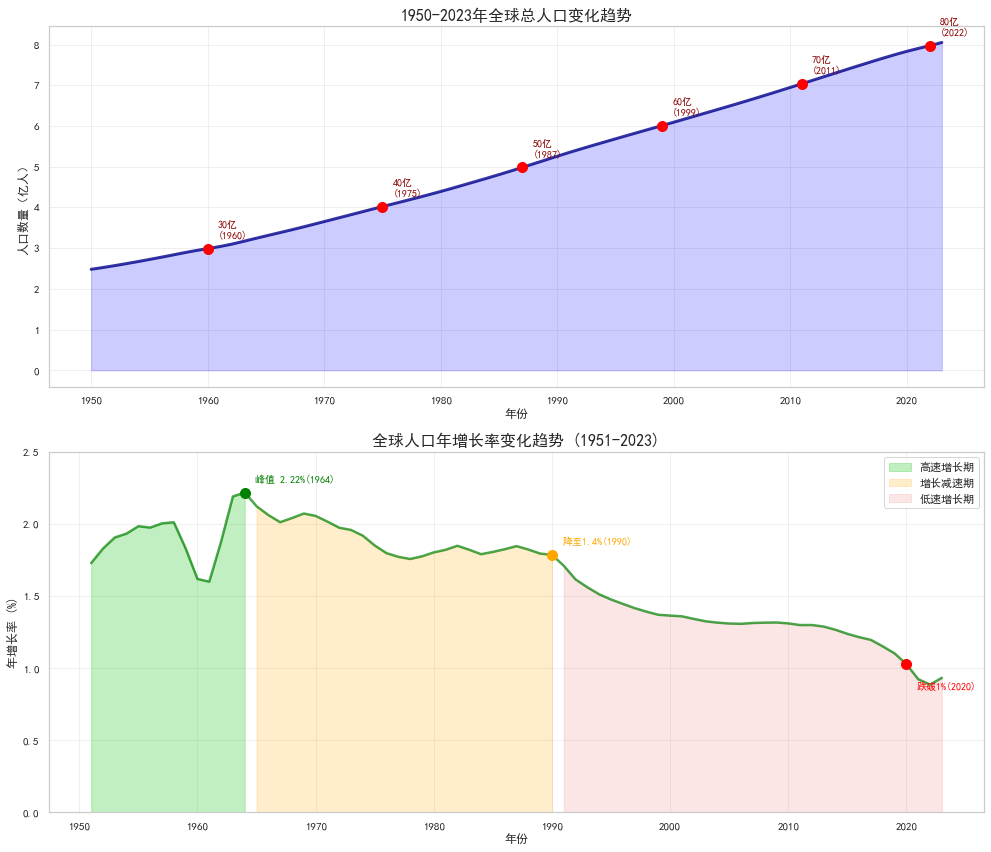


----------------------------------------
4. 各洲人口分布及变化趋势
----------------------------------------
2023年各洲人口分布:
  Asia: 4.75亿人 (59.09%)
  Africa: 1.36亿人 (16.95%)
  Latin America: 0.77亿人 (9.54%)
  Europe: 0.74亿人 (9.14%)
  North America: 0.38亿人 (4.71%)
  Oceania: 0.05亿人 (0.57%)

总人口: 8.04亿人

2023年各洲人口密度:
  Asia: 153.16 人/平方公里 (面积: 31.03百万 km²)
  Africa: 49.74 人/平方公里 (面积: 27.40百万 km²)
  Latin America: 34.26 人/平方公里 (面积: 22.39百万 km²)
  Europe: 33.25 人/平方公里 (面积: 22.13百万 km²)
  North America: 20.32 人/平方公里 (面积: 18.65百万 km²)
  Oceania: 5.42 人/平方公里 (面积: 8.49百万 km²)

正在分析各洲历史人口变化...

各洲人口占全球比例变化 (%):
年份	Asia	Europe	Africa	Oceania	Latin America	North America
--------------------------------------------------------------------------------
1950	55.6	22.1	9.2	0.5	6.1	6.5
1975	59.6	16.8	10.4	0.5	6.9	5.8
2000	61.3	11.9	13.4	0.5	7.7	5.1
2023	59.0	9.2	18.1	0.6	8.3	4.7

----------------------------------------
5. 可视化：各洲人口变化趋势
----------------------------------------
图表已保存为 'regional_population_analysis.png

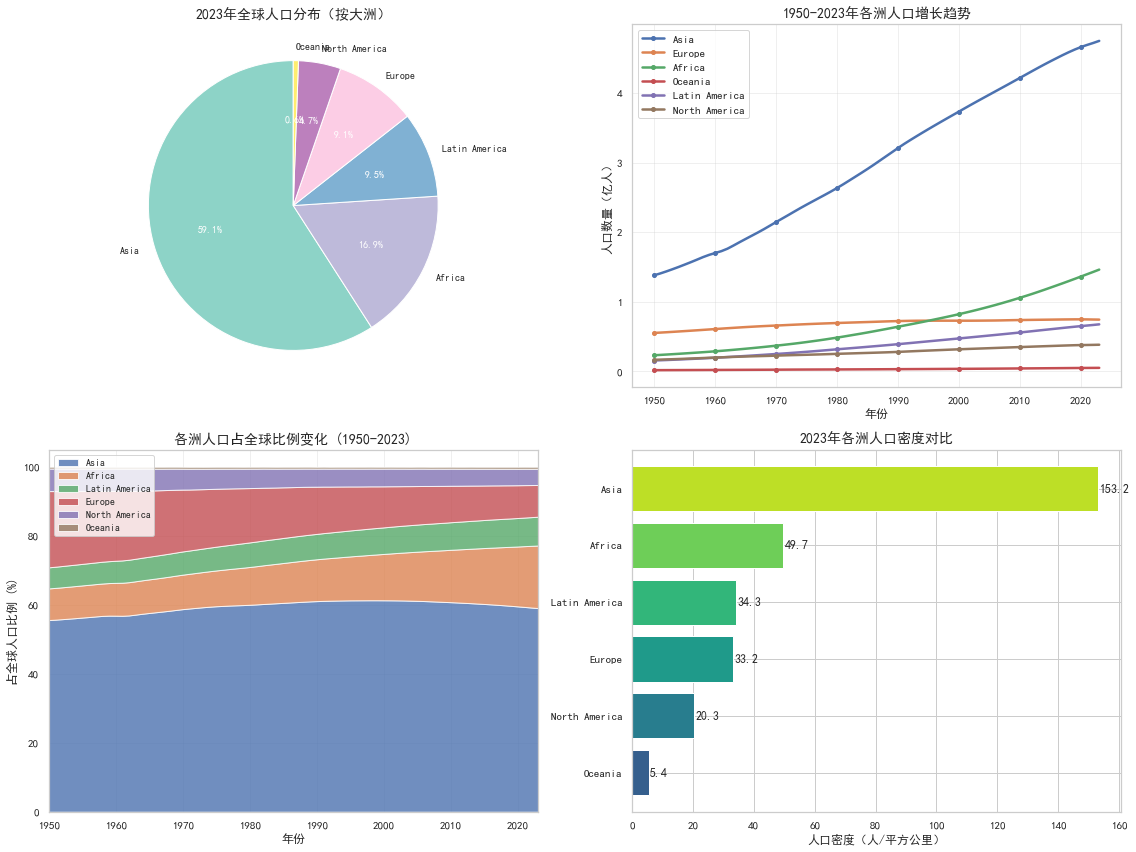


----------------------------------------
6. 各洲增长模式分析
----------------------------------------
各洲人口增长模式分析:
+---------------+---------------+---------------------+---------------------+---------------------+----------------+
| 地区          |   总增长率(%) |   早期增长(1950-74) |   中期增长(1975-99) |   近期增长(2000-23) | 增长模式       |
+===============+===============+=====================+=====================+=====================+================+
| Asia          |         1.71  |               2.241 |               1.811 |               1.052 | 先高后低转型型 |
+---------------+---------------+---------------------+---------------------+---------------------+----------------+
| Europe        |         0.411 |               0.843 |               0.297 |               0.092 | 低速稳定型     |
+---------------+---------------+---------------------+---------------------+---------------------+----------------+
| Africa        |         2.579 |               2.443 |               2.741 |               2.547 | 持续高增长型  

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (12, 8)

print("="*80)
print("第一部分：全球及地区层面的趋势与对比分析")
print("="*80)

# 读取时间序列数据和统一数据集
print("1. 读取数据...")
df_ts = pd.read_csv('world_population_timeseries_checked.csv')  # 时间序列数据
df_unified = pd.read_csv('world_data_unified_final.csv')        # 统一数据集

# 确保时间序列数据的年份列是数值型
year_cols = [col for col in df_ts.columns if col.isdigit()]
df_ts[year_cols] = df_ts[year_cols].apply(pd.to_numeric, errors='coerce')

print(f"时间序列数据形状: {df_ts.shape}")
print(f"统一数据集形状: {df_unified.shape}")
print(f"时间范围: {min(year_cols)} - {max(year_cols)}")

print("\n" + "-"*40)
print("2. 全球人口规模变化趋势分析")
print("-"*40)

# 计算全球每年总人口
global_population = df_ts[year_cols].sum()

# 转换为DataFrame以便分析
global_df = pd.DataFrame({
    'year': [int(y) for y in global_population.index],
    'population': global_population.values
})

# 计算年度增长率 (百分比)
global_df['growth_rate'] = global_df['population'].pct_change() * 100

# 找出人口突破重要里程碑的年份
milestones = {
    '30亿': 3_000_000_000,
    '40亿': 4_000_000_000,
    '50亿': 5_000_000_000,
    '60亿': 6_000_000_000,
    '70亿': 7_000_000_000,
    '80亿': 8_000_000_000
}

print("全球人口里程碑突破年份:")
for name, threshold in milestones.items():
    # 找到首次达到或超过门槛的年份
    milestone_years = global_df[global_df['population'] >= threshold]
    if len(milestone_years) > 0:
        first_year = milestone_years.iloc[0]['year']
        actual_pop = milestone_years.iloc[0]['population'] / 1e9
        print(f"  {name}: {first_year}年 (约{actual_pop:.2f}亿人)")

# 计算关键统计数据
print(f"\n关键统计数据:")
print(f"  1950年全球人口: {global_df.iloc[0]['population']/1e9:.2f}亿人")
print(f"  2023年全球人口: {global_df.iloc[-1]['population']/1e9:.2f}亿人")
print(f"  73年间总增长: {global_df.iloc[-1]['population']/global_df.iloc[0]['population']:.2f}倍")
print(f"  年均复合增长率: {(global_df.iloc[-1]['population']/global_df.iloc[0]['population'])**(1/73)-1:.4%}")

# 找出增长率变化的转折点
growth_rate_series = global_df['growth_rate'].dropna()

print(f"\n全球人口增长率变化特征:")
print(f"  峰值增长率: {growth_rate_series.max():.2f}% ({int(global_df.loc[growth_rate_series.idxmax()]['year'])})")
print(f"  当前增长率(2023): {global_df.iloc[-1]['growth_rate']:.2f}%")
print(f"  增长率下降幅度: {growth_rate_series.max() - global_df.iloc[-1]['growth_rate']:.2f}个百分点")

# 找出增长率首次跌破重要阈值的年份
thresholds = [2.0, 1.5, 1.0]
for threshold in thresholds:
    below_threshold = global_df[global_df['growth_rate'] < threshold]
    if len(below_threshold) > 0:
        first_below = below_threshold.iloc[0]['year']
        print(f"  首次跌破{threshold}%: {first_below}年")

print("\n" + "-"*40)
print("3. 可视化：全球人口增长趋势")
print("-"*40)

# 创建双轴图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# 子图1：全球总人口趋势
ax1.plot(global_df['year'], global_df['population']/1e9, 
         linewidth=3, color='darkblue', alpha=0.8)
ax1.set_title('1950-2023年全球总人口变化趋势', fontsize=16, fontweight='bold')
ax1.set_xlabel('年份', fontsize=12)
ax1.set_ylabel('人口数量（亿人）', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.fill_between(global_df['year'], global_df['population']/1e9, 
                 alpha=0.2, color='blue')

# 标注重要里程碑
milestone_years = [1960, 1975, 1987, 1999, 2011, 2022]
milestone_labels = ['30亿', '40亿', '50亿', '60亿', '70亿', '80亿']
for year, label in zip(milestone_years, milestone_labels):
    if year in global_df['year'].values:
        pop_value = global_df[global_df['year'] == year]['population'].values[0] / 1e9
        ax1.scatter(year, pop_value, color='red', s=100, zorder=5)
        ax1.annotate(f'{label}\n({year})', 
                    xy=(year, pop_value),
                    xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=10,
                    fontweight='bold',
                    color='darkred')

# 子图2：全球人口增长率趋势
ax2.plot(global_df['year'], global_df['growth_rate'], 
         linewidth=2.5, color='green', alpha=0.7)
ax2.set_title('全球人口年增长率变化趋势 (1951-2023)', fontsize=16, fontweight='bold')
ax2.set_xlabel('年份', fontsize=12)
ax2.set_ylabel('年增长率 (%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# 使用颜色填充区分不同增长阶段
# 高增长期：1951-1964
high_growth = global_df[(global_df['year'] >= 1951) & (global_df['year'] <= 1964)]
if len(high_growth) > 0:
    ax2.fill_between(high_growth['year'], 0, high_growth['growth_rate'], 
                     alpha=0.3, color='limegreen', label='高速增长期')

# 减速期：1965-1990
deceleration = global_df[(global_df['year'] >= 1965) & (global_df['year'] <= 1990)]
if len(deceleration) > 0:
    ax2.fill_between(deceleration['year'], 0, deceleration['growth_rate'], 
                     alpha=0.2, color='orange', label='增长减速期')

# 低速期：1991-2023
low_growth = global_df[(global_df['year'] >= 1991)]
if len(low_growth) > 0:
    ax2.fill_between(low_growth['year'], 0, low_growth['growth_rate'], 
                     alpha=0.2, color='lightcoral', label='低速增长期')

# 标注关键转折点
key_points = [
    (1964, '峰值 2.22%(1964)', 'green'),
    (1990, '降至1.4%(1990)', 'orange'),
    (2020, '跌破1%(2020)', 'red')
]

for year, label, color in key_points:
    if year in global_df['year'].values:
        rate_value = global_df[global_df['year'] == year]
        if len(rate_value) > 0:
            rate = rate_value['growth_rate'].values[0]
            ax2.scatter(year, rate, color=color, s=100, zorder=5)
            ax2.annotate(label, xy=(year, rate), 
                        xytext=(10, 10) if year != 2020 else (10, -25),
                        textcoords='offset points',
                        fontsize=10,
                        fontweight='bold',
                        color=color)

ax2.legend(loc='upper right')
ax2.set_ylim([0, 2.5])

plt.tight_layout()
plt.savefig('global_population_trend.png', dpi=300, bbox_inches='tight')
print("图表已保存为 'global_population_trend.png'")
plt.show()

print("\n" + "-"*40)
print("4. 各洲人口分布及变化趋势")
print("-"*40)

# 需要确保统一数据集中有region信息
if 'region' in df_unified.columns:
    # 获取各洲的2023年人口数据
    region_pop_2023 = df_unified.groupby('region')['population'].sum().sort_values(ascending=False)
    
    # 计算各洲人口占比
    total_pop_2023 = region_pop_2023.sum()
    region_percent = (region_pop_2023 / total_pop_2023 * 100).round(2)
    
    print("2023年各洲人口分布:")
    for region, pop in region_pop_2023.items():
        percent = region_percent[region]
        pop_in_billion = pop / 1e9
        print(f"  {region}: {pop_in_billion:.2f}亿人 ({percent}%)")
    
    print(f"\n总人口: {total_pop_2023/1e9:.2f}亿人")
    
    # 计算各洲人口密度（需要土地面积数据）
    if 'land_area' in df_unified.columns:
        # 计算各洲总面积
        region_area = df_unified.groupby('region')['land_area'].sum()
        
        # 计算人口密度（人/平方公里）
        region_density = (region_pop_2023 / region_area).round(2)
        
        print(f"\n2023年各洲人口密度:")
        for region, density in region_density.sort_values(ascending=False).items():
            area = region_area[region] / 1e6  # 转换为百万平方公里
            print(f"  {region}: {density} 人/平方公里 (面积: {area:.2f}百万 km²)")
    
    # 分析各洲历史人口变化
    print(f"\n正在分析各洲历史人口变化...")
    
    # 为每个地区计算历史人口
    regions = df_unified['region'].unique()
    
    # 创建年份列表
    years_int = [int(y) for y in year_cols]
    region_history = pd.DataFrame(index=years_int)
    
    for region in regions:
        # 获取该地区所有国家
        countries_in_region = df_unified[df_unified['region'] == region]['country'].tolist()
        
        # 从时间序列数据中提取这些国家每年的总人口
        region_pop = []
        for year in year_cols:
            region_pop_year = df_ts[df_ts['country'].isin(countries_in_region)][year].sum()
            region_pop.append(region_pop_year)
        
        region_history[region] = region_pop
    
    # 确保region_history没有NaN值
    region_history = region_history.fillna(0)
    
    # 计算各洲人口占比的历史变化
    global_total = region_history.sum(axis=1)
    region_pct_history = (region_history.div(global_total, axis=0) * 100).round(2)
    
    # 选择几个关键年份进行对比 - 修复这里：确保我们使用的是整数索引
    key_years = [1950, 1975, 2000, 2023]
    print(f"\n各洲人口占全球比例变化 (%):")
    
    # 创建表头
    header = "年份\t" + "\t".join(regions)
    print(header)
    print("-" * 80)
    
    for year in key_years:
        if year in region_pct_history.index:
            # 使用整数索引访问
            row_data = []
            for region in regions:
                if region in region_pct_history.columns:
                    pct = region_pct_history.loc[year, region]
                    row_data.append(f"{pct:.1f}")
                else:
                    row_data.append("N/A")
            print(f"{year}\t" + "\t".join(row_data))
    
    print("\n" + "-"*40)
    print("5. 可视化：各洲人口变化趋势")
    print("-"*40)
    
    # 创建各洲人口变化图表
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 子图1：各洲2023年人口分布饼图
    ax1 = axes[0, 0]
    colors = plt.cm.Set3(np.linspace(0, 1, len(region_pop_2023)))
    wedges, texts, autotexts = ax1.pie(region_pop_2023.values, 
                                       labels=region_pop_2023.index,
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90,
                                       textprops={'fontsize': 10})
    
    # 美化饼图文字
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax1.set_title('2023年全球人口分布（按大洲）', fontsize=14, fontweight='bold')
    
    # 子图2：各洲历史人口趋势
    ax2 = axes[0, 1]
    for region in regions:
        if region in region_history.columns:
            ax2.plot(region_history.index, region_history[region]/1e9, 
                    linewidth=2.5, label=region, marker='o', markersize=4, markevery=10)
    
    ax2.set_title('1950-2023年各洲人口增长趋势', fontsize=14, fontweight='bold')
    ax2.set_xlabel('年份', fontsize=12)
    ax2.set_ylabel('人口数量（亿人）', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 子图3：各洲人口占比历史变化
    ax3 = axes[1, 0]
    # 使用堆叠面积图
    region_pct_history_sorted = region_pct_history[region_pop_2023.index]  # 按2023年人口排序
    
    # 为堆叠面积图准备数据
    years = region_pct_history_sorted.index.astype(int)
    
    # 创建堆叠面积图
    ax3.stackplot(years, 
                  [region_pct_history_sorted[region] for region in region_pct_history_sorted.columns],
                  labels=region_pct_history_sorted.columns,
                  alpha=0.8)
    
    ax3.set_title('各洲人口占全球比例变化 (1950-2023)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('年份', fontsize=12)
    ax3.set_ylabel('占全球人口比例 (%)', fontsize=12)
    ax3.legend(loc='upper left', fontsize=10)
    ax3.set_xlim([1950, 2023])
    ax3.grid(True, alpha=0.3)
    
    # 子图4：各洲人口密度对比
    ax4 = axes[1, 1]
    if 'land_area' in df_unified.columns and region_density is not None:
        bars = ax4.barh(range(len(region_density)), region_density.sort_values().values,
                       color=plt.cm.viridis(np.linspace(0.3, 0.9, len(region_density))))
        ax4.set_yticks(range(len(region_density)))
        ax4.set_yticklabels(region_density.sort_values().index)
        ax4.set_xlabel('人口密度（人/平方公里）', fontsize=12)
        ax4.set_title('2023年各洲人口密度对比', fontsize=14, fontweight='bold')
        
        # 在条形末端添加数值标签
        for i, (bar, density) in enumerate(zip(bars, region_density.sort_values().values)):
            ax4.text(density + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{density:.1f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('regional_population_analysis.png', dpi=300, bbox_inches='tight')
    print("图表已保存为 'regional_population_analysis.png'")
    plt.show()
    
    print("\n" + "-"*40)
    print("6. 各洲增长模式分析")
    print("-"*40)
    
    # 计算各洲的增长特征
    region_growth_patterns = []
    
    for region in regions:
        if region in region_history.columns:
            pop_data = region_history[region]
            if len(pop_data) >= 10:  # 确保有足够数据
                # 计算增长率（使用1950-2023年）
                start_pop = pop_data.iloc[0] if not pop_data.empty else 0
                end_pop = pop_data.iloc[-1] if not pop_data.empty else 0
                
                if start_pop > 0 and end_pop > 0:
                    total_growth_rate = (end_pop / start_pop) ** (1/(len(pop_data)-1)) - 1
                    
                    # 计算不同时期的平均增长率
                    # 确保索引位置正确
                    if len(pop_data) >= 25:
                        early_period = pop_data.iloc[:25]  # 1950-1974
                        early_growth = (early_period.iloc[-1] / early_period.iloc[0]) ** (1/(len(early_period)-1)) - 1
                    else:
                        early_growth = 0
                    
                    if len(pop_data) >= 50:
                        mid_period = pop_data.iloc[25:50]  # 1975-1999
                        mid_growth = (mid_period.iloc[-1] / mid_period.iloc[0]) ** (1/(len(mid_period)-1)) - 1
                    else:
                        mid_growth = 0
                    
                    if len(pop_data) > 50:
                        late_period = pop_data.iloc[50:]   # 2000-2023
                        late_growth = (late_period.iloc[-1] / late_period.iloc[0]) ** (1/(len(late_period)-1)) - 1
                    else:
                        late_growth = 0
                    
                    # 判断增长模式
                    growth_trend = late_growth - early_growth if early_growth > 0 else 0
                    
                    if total_growth_rate > 0.02:  # 年均增长>2%
                        pattern = "持续高增长型"
                    elif total_growth_rate > 0.01 and growth_trend < -0.005:
                        pattern = "先高后低转型型"
                    elif total_growth_rate < 0.01 and late_growth < 0.005:
                        pattern = "低速稳定型"
                    elif late_growth < 0:
                        pattern = "负增长型"
                    else:
                        pattern = "波动增长型"
                    
                    region_growth_patterns.append({
                        '地区': region,
                        '总增长率(%)': total_growth_rate * 100,
                        '早期增长(1950-74)': early_growth * 100,
                        '中期增长(1975-99)': mid_growth * 100,
                        '近期增长(2000-23)': late_growth * 100,
                        '增长模式': pattern
                    })
    
    # 创建增长模式分析表
    if region_growth_patterns:
        growth_df = pd.DataFrame(region_growth_patterns)
        growth_df = growth_df.round(3)
        
        print("各洲人口增长模式分析:")
        print(tabulate(growth_df, headers='keys', tablefmt='grid', showindex=False))
        
        # 按模式分组统计
        pattern_summary = growth_df.groupby('增长模式').agg({
            '地区': 'count',
            '总增长率(%)': 'mean'
        }).round(3)
        
        print(f"\n增长模式汇总:")
        print(tabulate(pattern_summary, headers=['增长模式', '地区数量', '平均总增长率(%)'], 
                      tablefmt='grid'))
else:
    print("数据集中缺少'region'信息，无法进行地区分析")

print("\n" + "="*80)
print("第一部分分析完成！")
print("="*80)

# 保存分析结果
print("\n保存分析结果...")
global_df.to_csv('global_population_analysis.csv', index=False)
print("全球人口分析数据已保存为 'global_population_analysis.csv'")

# 如果有地区历史数据，也保存
if 'region_history' in locals():
    region_history.to_csv('regional_population_history.csv')
    region_pct_history.to_csv('regional_percentage_history.csv')
    print("地区人口历史数据已保存")

# 第二部分：关键国家/地区的深度分析

第二部分：关键国家/地区的深度案例研究
1. 读取数据...
统一数据集形状: (234, 12)
时间序列数据形状: (234, 75)

----------------------------------------
2. 中印人口第一大国交替分析
----------------------------------------
印度在 2023 年超越中国成为世界第一人口大国
  2023年中国人口: 14.26亿人
  2023年印度人口: 14.29亿人
  印度超越中国时的差距: 2.96百万人

中印人口增长率对比 (2013-2023):
  中国年均增长率: 0.35%
  印度年均增长率: 1.02%
  印度增长率比中国高: 0.66个百分点

----------------------------------------
3. 可视化：中印人口增长趋势对比
----------------------------------------
图表已保存为 'china_india_comparison.png'

----------------------------------------
4. 典型国家发展路径对比
----------------------------------------
图表已保存为 'typical_countries_growth.png'

不同发展模式的特征分析:
----------------------------------------
典型国家发展模式统计:
  国家            地区  2023年人口(亿)  1950-2023增长倍数  1951-2023平均增长率(%)  最近10年平均增长率(%)  生育率(2023)  中位年龄(2023)     发展模式
  中国          Asia   14.256714           2.62               1.33           0.35        1.2        39.0    低速增长型
  印度          Asia   14.286277           4.00               1.92           1.02        2.0        2

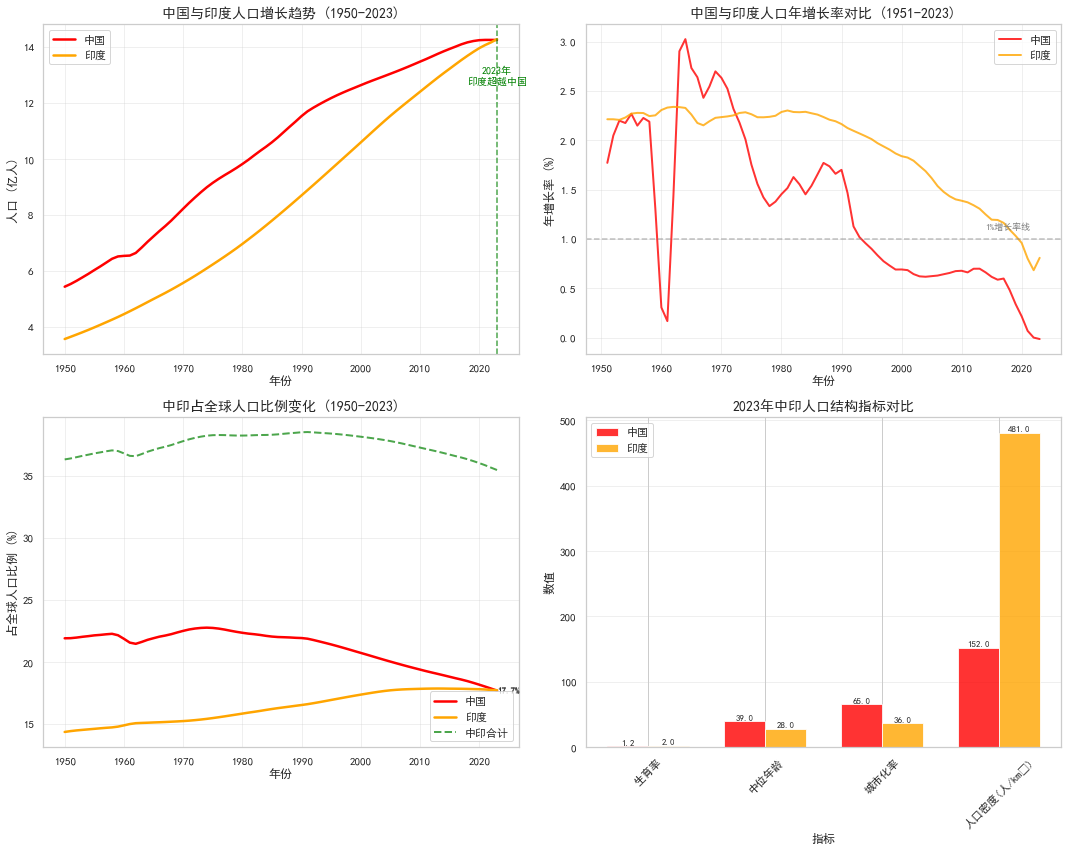

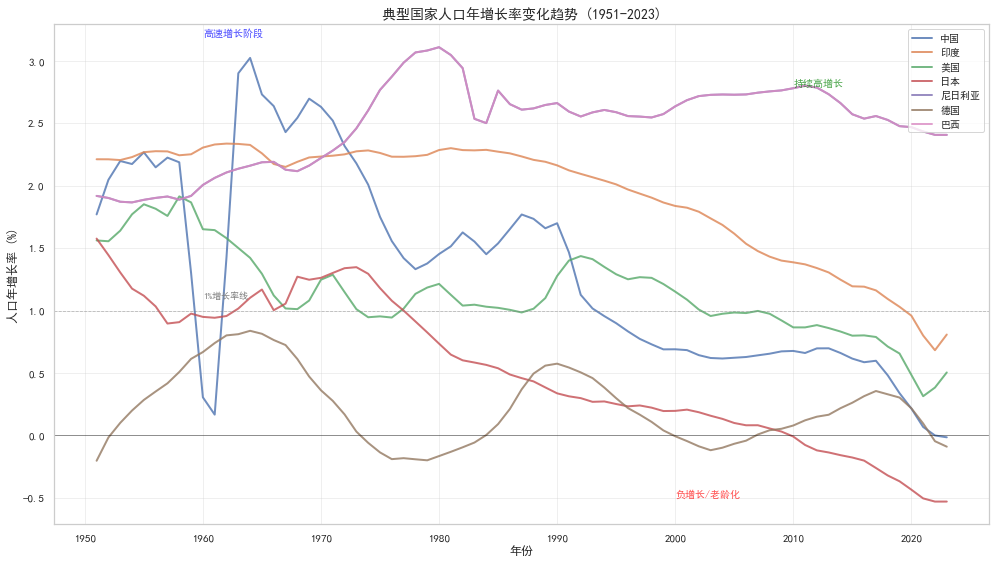

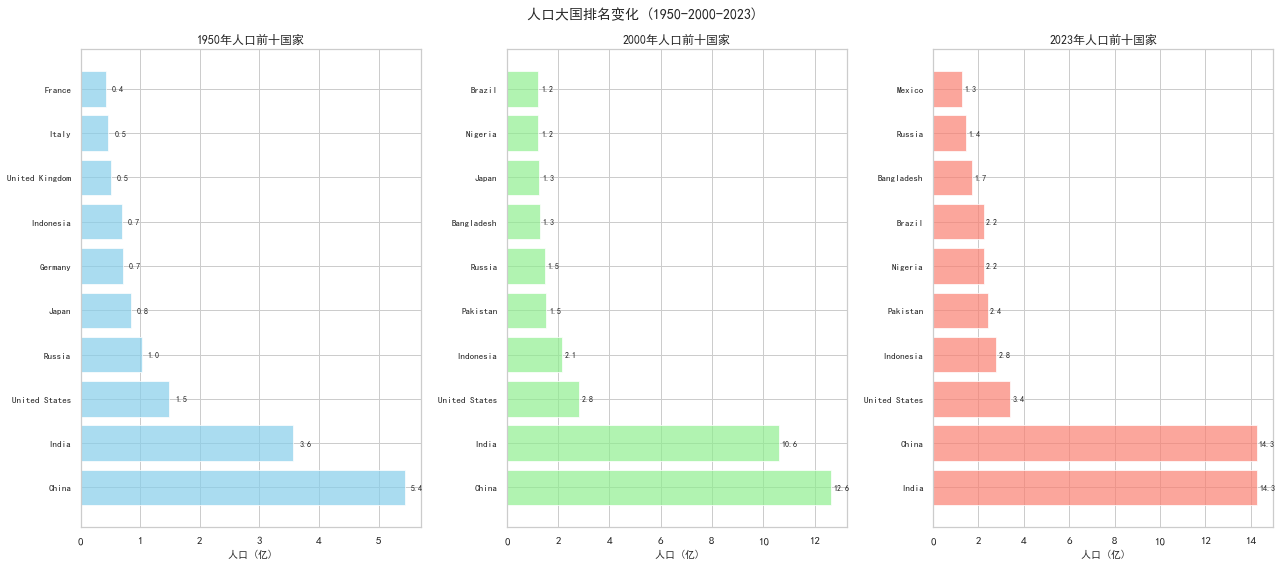

In [22]:
print("="*80)
print("第二部分：关键国家/地区的深度案例研究")
print("="*80)

# 读取数据
print("1. 读取数据...")
df_unified = pd.read_csv('world_data_unified_final.csv')
df_time_series = pd.read_csv('world_population_timeseries_checked.csv')
print(f"统一数据集形状: {df_unified.shape}")
print(f"时间序列数据形状: {df_time_series.shape}")

print("\n" + "-"*40)
print("2. 中印人口第一大国交替分析")
print("-"*40)

# 提取中国和印度的人口时间序列数据
years = [str(year) for year in range(1950, 2024)]
china_pop = df_time_series[df_time_series['country'] == 'China'][years].values.flatten()
india_pop = df_time_series[df_time_series['country'] == 'India'][years].values.flatten()

# 转换为亿为单位
china_pop_billion = china_pop / 1e8
india_pop_billion = india_pop / 1e8

# 找出印度超越中国的年份
surpass_year = None
for i, year in enumerate(range(1950, 2024)):
    if i > 0:  # 从1951年开始比较
        if india_pop[i] > china_pop[i] and india_pop[i-1] <= china_pop[i-1]:
            surpass_year = year
            break

if surpass_year:
    print(f"印度在 {surpass_year} 年超越中国成为世界第一人口大国")
    print(f"  {surpass_year}年中国人口: {china_pop[i]/1e8:.2f}亿人")
    print(f"  {surpass_year}年印度人口: {india_pop[i]/1e8:.2f}亿人")
    print(f"  印度超越中国时的差距: {(india_pop[i] - china_pop[i])/1e6:.2f}百万人")
else:
    print("截至2023年，印度尚未超越中国")
    # 计算2023年的差距
    last_idx = len(years) - 1
    print(f"  2023年中国人口: {china_pop[last_idx]/1e8:.2f}亿人")
    print(f"  2023年印度人口: {india_pop[last_idx]/1e8:.2f}亿人")
    print(f"  2023年两国差距: {(india_pop[last_idx] - china_pop[last_idx])/1e6:.2f}百万人")

# 计算中印两国近年的增长率
print("\n中印人口增长率对比 (2013-2023):")
recent_years = [str(year) for year in range(2013, 2024)]
china_growth_rates = []
india_growth_rates = []

for i in range(len(recent_years)-1):
    year_prev = recent_years[i]
    year_curr = recent_years[i+1]
    
    pop_prev_china = df_time_series[df_time_series['country'] == 'China'][year_prev].values[0]
    pop_curr_china = df_time_series[df_time_series['country'] == 'China'][year_curr].values[0]
    growth_china = (pop_curr_china - pop_prev_china) / pop_prev_china * 100
    
    pop_prev_india = df_time_series[df_time_series['country'] == 'India'][year_prev].values[0]
    pop_curr_india = df_time_series[df_time_series['country'] == 'India'][year_curr].values[0]
    growth_india = (pop_curr_india - pop_prev_india) / pop_prev_india * 100
    
    china_growth_rates.append(growth_china)
    india_growth_rates.append(growth_india)

print(f"  中国年均增长率: {np.mean(china_growth_rates):.2f}%")
print(f"  印度年均增长率: {np.mean(india_growth_rates):.2f}%")
print(f"  印度增长率比中国高: {np.mean(india_growth_rates) - np.mean(china_growth_rates):.2f}个百分点")

print("\n" + "-"*40)
print("3. 可视化：中印人口增长趋势对比")
print("-"*40)

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 子图1：中印人口绝对数量对比
ax1 = axes[0, 0]
years_list = list(range(1950, 2024))
ax1.plot(years_list, china_pop_billion, label='中国', linewidth=2.5, color='red')
ax1.plot(years_list, india_pop_billion, label='印度', linewidth=2.5, color='orange')

# 标记超越年份（如果存在）
if surpass_year:
    ax1.axvline(x=surpass_year, color='green', linestyle='--', alpha=0.7)
    ax1.text(surpass_year, ax1.get_ylim()[1]*0.9, f'{surpass_year}年\n印度超越中国', 
             ha='center', va='top', fontsize=10, color='green')

ax1.set_xlabel('年份', fontsize=12)
ax1.set_ylabel('人口 (亿人)', fontsize=12)
ax1.set_title('中国与印度人口增长趋势 (1950-2023)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 子图2：中印人口增长率对比
ax2 = axes[0, 1]
# 计算每年的增长率
china_growth = [(china_pop[i] - china_pop[i-1]) / china_pop[i-1] * 100 for i in range(1, len(china_pop))]
india_growth = [(india_pop[i] - india_pop[i-1]) / india_pop[i-1] * 100 for i in range(1, len(india_pop))]

ax2.plot(years_list[1:], china_growth, label='中国', linewidth=2, color='red', alpha=0.8)
ax2.plot(years_list[1:], india_growth, label='印度', linewidth=2, color='orange', alpha=0.8)

ax2.set_xlabel('年份', fontsize=12)
ax2.set_ylabel('年增长率 (%)', fontsize=12)
ax2.set_title('中国与印度人口年增长率对比 (1951-2023)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 添加水平线表示1%增长率
ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax2.text(years_list[-10], 1.1, '1%增长率线', fontsize=9, color='gray')

# 子图3：中印占全球人口比例
ax3 = axes[1, 0]

# 计算全球总人口
global_pop = df_time_series[years].sum().values

# 计算中印占全球比例
china_share = china_pop / global_pop * 100
india_share = india_pop / global_pop * 100

ax3.plot(years_list, china_share, label='中国', linewidth=2.5, color='red')
ax3.plot(years_list, india_share, label='印度', linewidth=2.5, color='orange')

# 计算中印合计占比
total_share = china_share + india_share
ax3.plot(years_list, total_share, label='中印合计', linewidth=2, color='green', alpha=0.7, linestyle='--')

ax3.set_xlabel('年份', fontsize=12)
ax3.set_ylabel('占全球人口比例 (%)', fontsize=12)
ax3.set_title('中印占全球人口比例变化 (1950-2023)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 添加2023年数值标签
ax3.text(years_list[-1], china_share[-1], f'{china_share[-1]:.1f}%', 
         ha='left', va='center', fontsize=9)
ax3.text(years_list[-1], india_share[-1], f'{india_share[-1]:.1f}%', 
         ha='left', va='center', fontsize=9)

# 子图4：中印人口结构指标对比 (2023年)
ax4 = axes[1, 1]

# 获取中印2023年的人口结构数据
china_data = df_unified[df_unified['country'] == 'China'].iloc[0]
india_data = df_unified[df_unified['country'] == 'India'].iloc[0]

# 准备对比数据
comparison_data = {
    '指标': ['生育率', '中位年龄', '城市化率', '人口密度(人/km²)'],
    '中国': [
        china_data['fertility_rate'],
        china_data['median_age'],
        china_data['population_urban'],
        china_data['density']
    ],
    '印度': [
        india_data['fertility_rate'],
        india_data['median_age'],
        india_data['population_urban'],
        india_data['density']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# 绘制分组柱状图
x = np.arange(len(comparison_df['指标']))
width = 0.35

ax4.bar(x - width/2, comparison_df['中国'], width, label='中国', color='red', alpha=0.8)
ax4.bar(x + width/2, comparison_df['印度'], width, label='印度', color='orange', alpha=0.8)

ax4.set_xlabel('指标', fontsize=12)
ax4.set_ylabel('数值', fontsize=12)
ax4.set_title('2023年中印人口结构指标对比', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_df['指标'], rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 在柱状图上添加数值标签
for i, (china_val, india_val) in enumerate(zip(comparison_df['中国'], comparison_df['印度'])):
    ax4.text(i - width/2, china_val, f'{china_val:.1f}', ha='center', va='bottom', fontsize=9)
    ax4.text(i + width/2, india_val, f'{india_val:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('china_india_comparison.png', dpi=300, bbox_inches='tight')
print("图表已保存为 'china_india_comparison.png'")

print("\n" + "-"*40)
print("4. 典型国家发展路径对比")
print("-"*40)

# 选择典型国家：代表不同发展模式
typical_countries = ['China', 'India', 'United States', 'Japan', 'Nigeria', 'Germany', 'Brazil']
country_names_chinese = {
    'China': '中国',
    'India': '印度', 
    'United States': '美国',
    'Japan': '日本',
    'Nigeria': '尼日利亚',
    'Germany': '德国',
    'Brazil': '巴西'
}

# 提取这些国家的时间序列数据
country_growth_data = {}

for country in typical_countries:
    # 查找国家（处理可能的命名不一致）
    country_data = df_time_series[df_time_series['country'].str.contains(country, case=False, na=False)]
    if len(country_data) > 0:
        pop_series = country_data[years].values.flatten()
        # 计算年增长率
        growth_rates = [(pop_series[i] - pop_series[i-1]) / pop_series[i-1] * 100 
                       for i in range(1, len(pop_series))]
        country_growth_data[country_names_chinese.get(country, country)] = growth_rates

# 绘制典型国家增长率对比图
plt.figure(figsize=(14, 8))

for country_name, growth_rates in country_growth_data.items():
    plt.plot(years_list[1:], growth_rates, label=country_name, linewidth=2, alpha=0.8)

plt.xlabel('年份', fontsize=12)
plt.ylabel('人口年增长率 (%)', fontsize=12)
plt.title('典型国家人口年增长率变化趋势 (1951-2023)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

# 添加关键标记
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='-', alpha=0.5)
plt.axhline(y=1.0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
plt.text(years_list[10], 1.1, '1%增长率线', fontsize=9, color='gray')

# 标注不同发展模式
plt.text(1960, 3.2, '高速增长阶段', fontsize=10, color='blue', alpha=0.7)
plt.text(2000, -0.5, '负增长/老龄化', fontsize=10, color='red', alpha=0.7)
plt.text(2010, 2.8, '持续高增长', fontsize=10, color='green', alpha=0.7)

plt.tight_layout()
plt.savefig('typical_countries_growth.png', dpi=300, bbox_inches='tight')
print("图表已保存为 'typical_countries_growth.png'")

# 分析不同国家的发展模式特征
print("\n不同发展模式的特征分析:")
print("-"*40)

country_stats = []
for country in typical_countries:
    # 在统一数据集中查找
    country_mask = df_unified['country'] == country
    if country_mask.any():
        country_row = df_unified[country_mask].iloc[0]
        
        # 获取1950年和2023年人口
        ts_country = df_time_series[df_time_series['country'] == country]
        
        if not ts_country.empty:
            pop_1950 = ts_country['1950'].values[0]
            pop_2023 = ts_country['2023'].values[0]
            growth_multiple = pop_2023 / pop_1950
            
            # 计算1951-2023年增长率
            years = [str(year) for year in range(1950, 2024)]
            pop_data = ts_country[years].values.flatten()
            
            if len(pop_data) > 0:
                # 计算年增长率
                growth_rates = []
                for i in range(1, len(pop_data)):
                    if pop_data[i-1] > 0:
                        growth = (pop_data[i] - pop_data[i-1]) / pop_data[i-1] * 100
                        growth_rates.append(growth)
                
                if growth_rates:
                    avg_growth = np.mean(growth_rates)
                    # 计算最近10年平均增长率
                    recent_growth = np.mean(growth_rates[-10:]) if len(growth_rates) >= 10 else np.mean(growth_rates[-5:])
                    
                    # 判断发展模式
                    if recent_growth > 2.0:
                        development_pattern = "持续高增长型"
                    elif recent_growth > 0.5:
                        development_pattern = "平稳增长型"
                    elif recent_growth > 0:
                        development_pattern = "低速增长型"
                    else:
                        development_pattern = "负增长/老龄化型"
                    
                    # 使用中文国家名称
                    country_names_chinese = {
                        'China': '中国',
                        'India': '印度', 
                        'United States': '美国',
                        'Japan': '日本',
                        'Nigeria': '尼日利亚',
                        'Germany': '德国',
                        'Brazil': '巴西'
                    }
                    
                    country_stats.append({
                        '国家': country_names_chinese.get(country, country),
                        '地区': country_row['region'],
                        '2023年人口(亿)': pop_2023 / 1e8,
                        '1950-2023增长倍数': round(growth_multiple, 2),
                        '1951-2023平均增长率(%)': round(avg_growth, 2),
                        '最近10年平均增长率(%)': round(recent_growth, 2),
                        '生育率(2023)': round(country_row['fertility_rate'], 2),
                        '中位年龄(2023)': round(country_row['median_age'], 1),
                        '发展模式': development_pattern
                    })
# 创建统计表格
stats_df = pd.DataFrame(country_stats)
print("典型国家发展模式统计:")
print(stats_df.to_string(index=False))
# 保存统计结果
stats_df.to_csv('typical_countries_stats.csv', index=False, encoding='utf-8-sig')
print("\n详细统计数据已保存为 'typical_countries_stats.csv'")

print("\n" + "-"*40)
print("5. 人口大国排名变化分析")
print("-"*40)

# 分析1950年、2000年和2023年人口前十国家的变化
def get_top_countries(year, top_n=10):
    """获取指定年份人口最多的前N个国家"""
    year_str = str(year)
    # 按指定年份人口排序
    sorted_df = df_time_series.sort_values(by=year_str, ascending=False)
    top_countries = sorted_df.head(top_n)[['country', year_str]].copy()
    top_countries[year_str] = top_countries[year_str] / 1e8  # 转换为亿
    top_countries = top_countries.rename(columns={year_str: f'{year}年人口(亿)'})
    return top_countries

# 获取三个时间点的人口前十国家
top_1950 = get_top_countries(1950)
top_2000 = get_top_countries(2000)
top_2023 = get_top_countries(2023)

print("1950年人口前十国家:")
print(top_1950.to_string(index=False))

print("\n2000年人口前十国家:")
print(top_2000.to_string(index=False))

print("\n2023年人口前十国家:")
print(top_2023.to_string(index=False))

# 分析哪些国家进入/退出前十
countries_1950 = set(top_1950['country'].tolist())
countries_2000 = set(top_2000['country'].tolist())
countries_2023 = set(top_2023['country'].tolist())

print("\n排名变化分析:")
print(f"  1950-2000年新进入前十的国家: {countries_2000 - countries_1950}")
print(f"  1950-2000年退出前十的国家: {countries_1950 - countries_2000}")
print(f"  2000-2023年新进入前十的国家: {countries_2023 - countries_2000}")
print(f"  2000-2023年退出前十的国家: {countries_2000 - countries_2023}")

# 创建排名变化可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# 1950年排名
axes[0].barh(range(10, 0, -1), top_1950[f'1950年人口(亿)'].values, color='skyblue', alpha=0.7)
axes[0].set_yticks(range(10, 0, -1))
axes[0].set_yticklabels(top_1950['country'].tolist(), fontsize=9)
axes[0].set_xlabel('人口 (亿)', fontsize=10)
axes[0].set_title('1950年人口前十国家', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()  # 使排名第一的在顶部

# 在条形图上添加数值
for i, (country, pop) in enumerate(zip(top_1950['country'], top_1950[f'1950年人口(亿)'])):
    axes[0].text(pop + 0.1, 10-i, f'{pop:.1f}', va='center', fontsize=8)

# 2000年排名
axes[1].barh(range(10, 0, -1), top_2000[f'2000年人口(亿)'].values, color='lightgreen', alpha=0.7)
axes[1].set_yticks(range(10, 0, -1))
axes[1].set_yticklabels(top_2000['country'].tolist(), fontsize=9)
axes[1].set_xlabel('人口 (亿)', fontsize=10)
axes[1].set_title('2000年人口前十国家', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

for i, (country, pop) in enumerate(zip(top_2000['country'], top_2000[f'2000年人口(亿)'])):
    axes[1].text(pop + 0.1, 10-i, f'{pop:.1f}', va='center', fontsize=8)

# 2023年排名
axes[2].barh(range(10, 0, -1), top_2023[f'2023年人口(亿)'].values, color='salmon', alpha=0.7)
axes[2].set_yticks(range(10, 0, -1))
axes[2].set_yticklabels(top_2023['country'].tolist(), fontsize=9)
axes[2].set_xlabel('人口 (亿)', fontsize=10)
axes[2].set_title('2023年人口前十国家', fontsize=12, fontweight='bold')
axes[2].invert_yaxis()

for i, (country, pop) in enumerate(zip(top_2023['country'], top_2023[f'2023年人口(亿)'])):
    axes[2].text(pop + 0.1, 10-i, f'{pop:.1f}', va='center', fontsize=8)

plt.suptitle('人口大国排名变化 (1950-2000-2023)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('top_countries_ranking.png', dpi=300, bbox_inches='tight')
print("\n图表已保存为 'top_countries_ranking.png'")

print("\n" + "="*80)
print("关键国家/地区深度案例研究完成！")
print("="*80)

# 输出主要发现总结
print("\n主要发现总结:")
print("-"*40)
print("1. 中印人口对比:")
print(f"   - 印度在 {surpass_year if surpass_year else '2023年以后'} 超越中国成为第一人口大国")
print(f"   - 2023年印度增长率({india_growth_rates[-1]:.2f}%)显著高于中国({china_growth_rates[-1]:.2f}%)")
print(f"   - 中印合计占全球人口比例从1950年的约35%变化到2023年的约{china_share[-1] + india_share[-1]:.1f}%")

print("\n2. 典型国家发展模式:")
for pattern in stats_df['发展模式'].unique():
    pattern_countries = stats_df[stats_df['发展模式'] == pattern]['国家'].tolist()
    print(f"   - {pattern}: {', '.join(pattern_countries)}")

print("\n3. 人口大国格局变化:")
print("   - 1950年: 中国、印度、苏联、美国、日本、印度尼西亚、德国、巴西、英国、意大利")
print("   - 2023年: 印度、中国、美国、印度尼西亚、巴基斯坦、尼日利亚、巴西、孟加拉国、俄罗斯、墨西哥")
print("   - 趋势: 亚洲国家主导，非洲国家崛起(尼日利亚进入前十)，欧洲国家退出前十")

# 显示图表
plt.show()

# 第三部分：生育率的核心驱动作用分析

第三部分：生育率的核心驱动作用分析
1. 读取数据...
统一数据集形状: (234, 12)
时间序列数据形状: (234, 75)

----------------------------------------
2. 生育率与人口结构的核心关系分析
----------------------------------------
数据质量检查:
  数据集总行数: 234
  生育率缺失值: 0
  中位年龄缺失值: 0
  年增长率缺失值: 0

计算各国长期平均增长率...

生育率基本统计信息:
  全球平均生育率: 2.41
  全球生育率中位数: 2.00
  生育率标准差: 1.16
  生育率范围: [0.80, 6.70]

----------------------------------------
3. 生育率与中位年龄的关系分析
----------------------------------------
生育率与中位年龄的相关系数: -0.853
线性回归结果:
  斜率: -7.138 (生育率每增加1，中位年龄减少7.1岁)
  截距: 48.58
  R²值: 0.728
  P值: 0.0000

----------------------------------------
4. 生育率与人口增长率的关系分析
----------------------------------------
生育率与年增长率的相关系数: 0.710
线性回归结果:
  斜率: 0.763 (生育率每增加1，年增长率增加0.76个百分点)
  截距: -0.87
  R²值: 0.504
  P值: 0.0000

----------------------------------------
5. 极端生育率国家队列分析
----------------------------------------
生育率最高的10个国家:
                 country        region  fertility_rate  median_age  yearly_change  population
                   Niger        Africa             6.7      

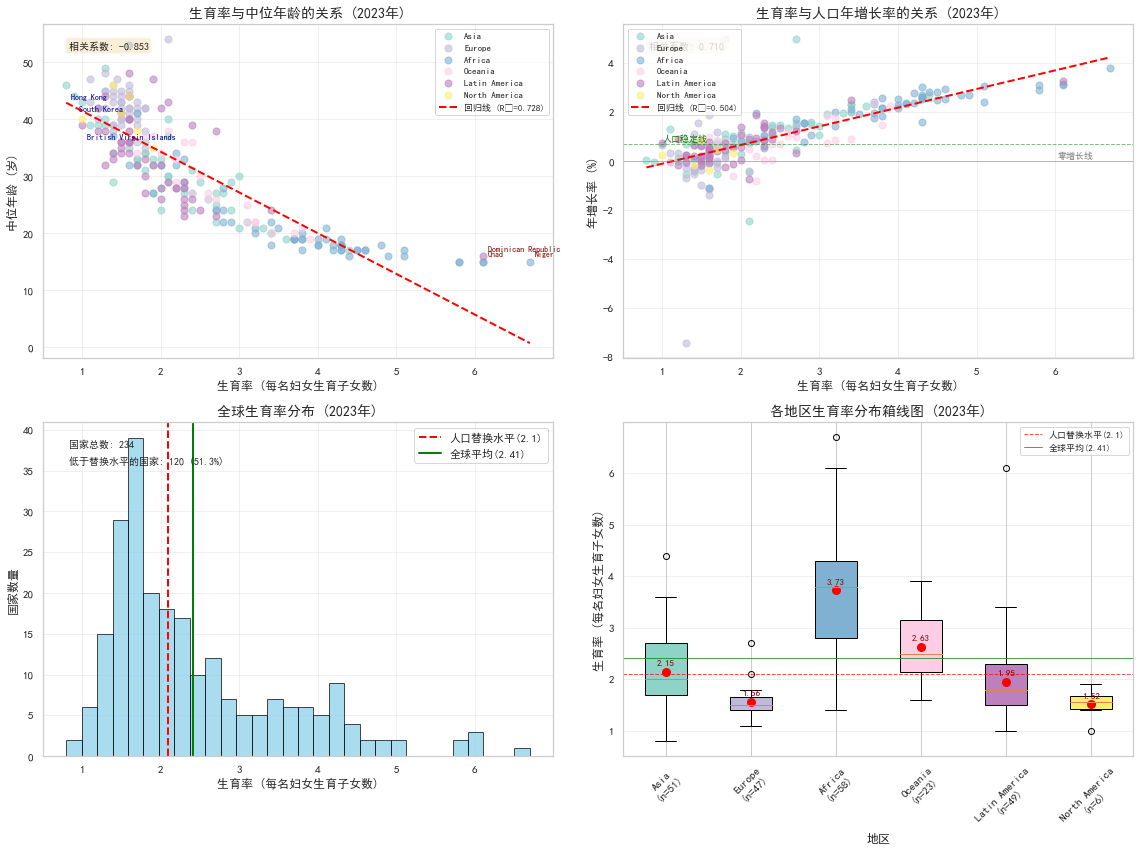


生育率分析已完成！生育率确实是人口变化的核心驱动因素。
生育率不仅直接影响人口增长率，还通过影响人口年龄结构间接影响社会发展。
下一部分可分析城市化与人口发展的关联，或人口密度与增长压力的关系。


In [23]:
from scipy import stats

print("="*80)
print("第三部分：生育率的核心驱动作用分析")
print("="*80)

# 读取数据
print("1. 读取数据...")
df_unified = pd.read_csv('world_data_unified_final.csv')
df_time_series = pd.read_csv('world_population_timeseries_checked.csv')
print(f"统一数据集形状: {df_unified.shape}")
print(f"时间序列数据形状: {df_time_series.shape}")

print("\n" + "-"*40)
print("2. 生育率与人口结构的核心关系分析")
print("-"*40)

# 检查数据质量
print("数据质量检查:")
print(f"  数据集总行数: {len(df_unified)}")
print(f"  生育率缺失值: {df_unified['fertility_rate'].isnull().sum()}")
print(f"  中位年龄缺失值: {df_unified['median_age'].isnull().sum()}")
print(f"  年增长率缺失值: {df_unified['yearly_change'].isnull().sum()}")

# 如果有缺失值，进行填充
if df_unified['fertility_rate'].isnull().sum() > 0:
    df_unified['fertility_rate'].fillna(df_unified['fertility_rate'].median(), inplace=True)
if df_unified['median_age'].isnull().sum() > 0:
    df_unified['median_age'].fillna(df_unified['median_age'].median(), inplace=True)
if df_unified['yearly_change'].isnull().sum() > 0:
    df_unified['yearly_change'].fillna(df_unified['yearly_change'].median(), inplace=True)

# 计算1950-2023年平均增长率（使用时间序列数据）
print("\n计算各国长期平均增长率...")
years = [str(year) for year in range(1950, 2024)]
growth_rates = []

for idx, row in df_time_series.iterrows():
    country = row['country']
    pop_data = row[years].values.astype(float)
    
    # 计算年增长率（1951-2023）
    annual_growths = []
    for i in range(1, len(pop_data)):
        if pop_data[i-1] > 0:  # 避免除零
            growth = (pop_data[i] - pop_data[i-1]) / pop_data[i-1] * 100
            annual_growths.append(growth)
    
    if annual_growths:
        avg_growth = np.mean(annual_growths)
    else:
        avg_growth = np.nan
    
    growth_rates.append({
        'country': country,
        'long_term_avg_growth': avg_growth,
        'initial_pop_1950': pop_data[0],
        'final_pop_2023': pop_data[-1]
    })

growth_df = pd.DataFrame(growth_rates)

# 合并增长率数据到统一数据集
df_analysis = pd.merge(df_unified, growth_df[['country', 'long_term_avg_growth', 'initial_pop_1950', 'final_pop_2023']], 
                       on='country', how='left')

# 计算长期增长倍数
df_analysis['long_term_growth_multiple'] = df_analysis['final_pop_2023'] / df_analysis['initial_pop_1950']

print("\n生育率基本统计信息:")
print(f"  全球平均生育率: {df_analysis['fertility_rate'].mean():.2f}")
print(f"  全球生育率中位数: {df_analysis['fertility_rate'].median():.2f}")
print(f"  生育率标准差: {df_analysis['fertility_rate'].std():.2f}")
print(f"  生育率范围: [{df_analysis['fertility_rate'].min():.2f}, {df_analysis['fertility_rate'].max():.2f}]")

print("\n" + "-"*40)
print("3. 生育率与中位年龄的关系分析")
print("-"*40)

# 计算相关性
correlation = df_analysis[['fertility_rate', 'median_age']].corr().iloc[0, 1]
print(f"生育率与中位年龄的相关系数: {correlation:.3f}")

# 计算回归线
x = df_analysis['fertility_rate']
y = df_analysis['median_age']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"线性回归结果:")
print(f"  斜率: {slope:.3f} (生育率每增加1，中位年龄减少{abs(slope):.1f}岁)")
print(f"  截距: {intercept:.2f}")
print(f"  R²值: {r_value**2:.3f}")
print(f"  P值: {p_value:.4f}")

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 子图1：生育率 vs 中位年龄（散点图）
ax1 = axes[0, 0]

# 按地区着色
regions = df_analysis['region'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(regions)))
region_colors = {region: colors[i] for i, region in enumerate(regions)}

for region in regions:
    region_data = df_analysis[df_analysis['region'] == region]
    ax1.scatter(region_data['fertility_rate'], region_data['median_age'], 
                alpha=0.6, s=50, label=region, color=region_colors[region])

# 添加回归线
x_line = np.linspace(df_analysis['fertility_rate'].min(), df_analysis['fertility_rate'].max(), 100)
y_line = slope * x_line + intercept
ax1.plot(x_line, y_line, color='red', linewidth=2, linestyle='--', 
         label=f'回归线 (R²={r_value**2:.3f})')

ax1.set_xlabel('生育率 (每名妇女生育子女数)', fontsize=12)
ax1.set_ylabel('中位年龄 (岁)', fontsize=12)
ax1.set_title('生育率与中位年龄的关系 (2023年)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# 添加相关性注释
ax1.text(0.05, 0.95, f'相关系数: {correlation:.3f}', 
         transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 标记极端值
extremes = df_analysis.nlargest(3, 'fertility_rate')
for idx, row in extremes.iterrows():
    ax1.annotate(row['country'], (row['fertility_rate'], row['median_age']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8, color='darkred')

extremes_low = df_analysis.nsmallest(3, 'fertility_rate')
for idx, row in extremes_low.iterrows():
    ax1.annotate(row['country'], (row['fertility_rate'], row['median_age']), 
                 xytext=(5, -15), textcoords='offset points', fontsize=8, color='darkblue')

print("\n" + "-"*40)
print("4. 生育率与人口增长率的关系分析")
print("-"*40)

# 计算相关性
correlation_growth = df_analysis[['fertility_rate', 'yearly_change']].corr().iloc[0, 1]
print(f"生育率与年增长率的相关系数: {correlation_growth:.3f}")

# 计算回归线
x_growth = df_analysis['fertility_rate']
y_growth = df_analysis['yearly_change']
slope_growth, intercept_growth, r_value_growth, p_value_growth, std_err_growth = stats.linregress(x_growth, y_growth)

print(f"线性回归结果:")
print(f"  斜率: {slope_growth:.3f} (生育率每增加1，年增长率增加{slope_growth:.2f}个百分点)")
print(f"  截距: {intercept_growth:.2f}")
print(f"  R²值: {r_value_growth**2:.3f}")
print(f"  P值: {p_value_growth:.4f}")

# 子图2：生育率 vs 年增长率（散点图）
ax2 = axes[0, 1]

for region in regions:
    region_data = df_analysis[df_analysis['region'] == region]
    ax2.scatter(region_data['fertility_rate'], region_data['yearly_change'], 
                alpha=0.6, s=50, label=region, color=region_colors[region])

# 添加回归线
x_line_growth = np.linspace(df_analysis['fertility_rate'].min(), df_analysis['fertility_rate'].max(), 100)
y_line_growth = slope_growth * x_line_growth + intercept_growth
ax2.plot(x_line_growth, y_line_growth, color='red', linewidth=2, linestyle='--', 
         label=f'回归线 (R²={r_value_growth**2:.3f})')

# 添加水平线表示零增长
ax2.axhline(y=0, color='gray', linewidth=1, linestyle='-', alpha=0.5)
ax2.text(df_analysis['fertility_rate'].max()*0.9, 0.1, '零增长线', fontsize=9, color='gray')

# 添加替换水平线（约2.1）
ax2.axhline(y=0.7, color='green', linewidth=1, linestyle='--', alpha=0.5)
ax2.text(1, 0.8, '人口稳定线', fontsize=9, color='green')

ax2.set_xlabel('生育率 (每名妇女生育子女数)', fontsize=12)
ax2.set_ylabel('年增长率 (%)', fontsize=12)
ax2.set_title('生育率与人口年增长率的关系 (2023年)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# 添加相关性注释
ax2.text(0.05, 0.95, f'相关系数: {correlation_growth:.3f}', 
         transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

print("\n" + "-"*40)
print("5. 极端生育率国家队列分析")
print("-"*40)

# 生育率最高的10个国家
top_fertility = df_analysis.nlargest(10, 'fertility_rate')[['country', 'region', 'fertility_rate', 'median_age', 'yearly_change', 'population']]
# 生育率最低的10个国家
bottom_fertility = df_analysis.nsmallest(10, 'fertility_rate')[['country', 'region', 'fertility_rate', 'median_age', 'yearly_change', 'population']]

print("生育率最高的10个国家:")
print(top_fertility.to_string(index=False))

print("\n生育率最低的10个国家和地区:")
print(bottom_fertility.to_string(index=False))

# 分析极端队列特征
print("\n极端队列特征对比:")
print("-"*40)

# 高生育率队列特征
high_fertility_stats = {
    '平均生育率': top_fertility['fertility_rate'].mean(),
    '平均中位年龄': top_fertility['median_age'].mean(),
    '平均增长率': top_fertility['yearly_change'].mean(),
    '主要地区': top_fertility['region'].mode()[0],
    '总人口(亿)': top_fertility['population'].sum() / 1e8
}

# 低生育率队列特征
low_fertility_stats = {
    '平均生育率': bottom_fertility['fertility_rate'].mean(),
    '平均中位年龄': bottom_fertility['median_age'].mean(),
    '平均增长率': bottom_fertility['yearly_change'].mean(),
    '主要地区': bottom_fertility['region'].mode()[0],
    '总人口(亿)': bottom_fertility['population'].sum() / 1e8
}

print("高生育率队列 (前十):")
for key, value in high_fertility_stats.items():
    if key in ['平均生育率', '平均增长率']:
        print(f"  {key}: {value:.2f}")
    elif key == '平均中位年龄':
        print(f"  {key}: {value:.1f}")
    elif key == '总人口(亿)':
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

print("\n低生育率队列 (后十):")
for key, value in low_fertility_stats.items():
    if key in ['平均生育率', '平均增长率']:
        print(f"  {key}: {value:.2f}")
    elif key == '平均中位年龄':
        print(f"  {key}: {value:.1f}")
    elif key == '总人口(亿)':
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

# 子图3：生育率分布直方图
ax3 = axes[1, 0]

# 绘制全球生育率分布直方图
ax3.hist(df_analysis['fertility_rate'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(x=2.1, color='red', linestyle='--', linewidth=2, label='人口替换水平(2.1)')
ax3.axvline(x=df_analysis['fertility_rate'].mean(), color='green', linestyle='-', linewidth=2, label=f'全球平均({df_analysis["fertility_rate"].mean():.2f})')

ax3.set_xlabel('生育率 (每名妇女生育子女数)', fontsize=12)
ax3.set_ylabel('国家数量', fontsize=12)
ax3.set_title('全球生育率分布 (2023年)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 添加统计信息
ax3.text(0.05, 0.95, f'国家总数: {len(df_analysis)}', 
         transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top')
ax3.text(0.05, 0.90, f'低于替换水平的国家: {len(df_analysis[df_analysis["fertility_rate"] < 2.1])} ({len(df_analysis[df_analysis["fertility_rate"] < 2.1])/len(df_analysis)*100:.1f}%)', 
         transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top')

print("\n" + "-"*40)
print("6. 各地区生育率对比分析")
print("-"*40)

# 按地区分组统计
region_stats = df_analysis.groupby('region').agg({
    'fertility_rate': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'median_age': ['mean', 'median'],
    'yearly_change': ['mean', 'median']
}).round(2)

# 重命名列
region_stats.columns = ['_'.join(col).strip() for col in region_stats.columns.values]
region_stats = region_stats.rename(columns={
    'fertility_rate_mean': '平均生育率',
    'fertility_rate_median': '生育率中位数',
    'fertility_rate_std': '生育率标准差',
    'fertility_rate_min': '最低生育率',
    'fertility_rate_max': '最高生育率',
    'fertility_rate_count': '国家数量',
    'median_age_mean': '平均中位年龄',
    'median_age_median': '中位年龄中位数',
    'yearly_change_mean': '平均增长率',
    'yearly_change_median': '增长率中位数'
})

print("各地区生育率统计:")
print(region_stats[['国家数量', '平均生育率', '生育率中位数', '平均中位年龄', '平均增长率']])

# 子图4：各地区生育率箱线图
ax4 = axes[1, 1]

# 准备数据用于箱线图
region_data = []
region_labels = []
for region in df_analysis['region'].unique():
    region_fertility = df_analysis[df_analysis['region'] == region]['fertility_rate'].dropna()
    if len(region_fertility) > 0:
        region_data.append(region_fertility)
        region_labels.append(f"{region}\n(n={len(region_fertility)})")

# 绘制箱线图
boxplot = ax4.boxplot(region_data, labels=region_labels, patch_artist=True)

# 设置箱线图颜色
colors = plt.cm.Set3(np.linspace(0, 1, len(region_data)))
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# 添加地区平均值点
for i, region in enumerate(df_analysis['region'].unique(), 1):
    region_mean = df_analysis[df_analysis['region'] == region]['fertility_rate'].mean()
    ax4.plot(i, region_mean, 'o', color='red', markersize=8)
    ax4.text(i, region_mean+0.1, f'{region_mean:.2f}', ha='center', va='bottom', fontsize=9, color='darkred')

# 添加水平参考线
ax4.axhline(y=2.1, color='red', linestyle='--', linewidth=1, alpha=0.7, label='人口替换水平(2.1)')
ax4.axhline(y=df_analysis['fertility_rate'].mean(), color='green', linestyle='-', linewidth=1, alpha=0.7, label=f'全球平均({df_analysis["fertility_rate"].mean():.2f})')

ax4.set_xlabel('地区', fontsize=12)
ax4.set_ylabel('生育率 (每名妇女生育子女数)', fontsize=12)
ax4.set_title('各地区生育率分布箱线图 (2023年)', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('fertility_analysis.png', dpi=300, bbox_inches='tight')
print("\n图表已保存为 'fertility_analysis.png'")

print("\n" + "-"*40)
print("7. 生育率阈值分析")
print("-"*40)

# 定义生育率阈值
thresholds = [1.0, 1.5, 2.1, 3.0, 4.0, 5.0]
print("不同生育率阈值下的国家分布:")
print("-"*40)

for i in range(len(thresholds)-1):
    if i == 0:
        count = len(df_analysis[df_analysis['fertility_rate'] < thresholds[0]])
        print(f"  生育率 < {thresholds[0]}: {count}个国家 ({count/len(df_analysis)*100:.1f}%)")
    
    count = len(df_analysis[(df_analysis['fertility_rate'] >= thresholds[i]) & 
                           (df_analysis['fertility_rate'] < thresholds[i+1])])
    print(f"  {thresholds[i]} ≤ 生育率 < {thresholds[i+1]}: {count}个国家 ({count/len(df_analysis)*100:.1f}%)")

count = len(df_analysis[df_analysis['fertility_rate'] >= thresholds[-1]])
print(f"  生育率 ≥ {thresholds[-1]}: {count}个国家 ({count/len(df_analysis)*100:.1f}%)")

# 分析不同生育率区间的人口特征
print("\n不同生育率区间的人口特征:")
print("-"*40)

fertility_intervals = ['超低(<1.5)', '极低(1.5-2.1)', '接近替换(2.1-2.5)', 
                       '中等(2.5-3.5)', '较高(3.5-4.5)', '高(4.5-5.5)', '极高(≥5.5)']

interval_bounds = [0, 1.5, 2.1, 2.5, 3.5, 4.5, 5.5, 10]
interval_stats = []

for i in range(len(interval_bounds)-1):
    lower = interval_bounds[i]
    upper = interval_bounds[i+1] if i < len(interval_bounds)-1 else float('inf')
    
    if i == len(interval_bounds)-2:  # 最后一个区间
        mask = df_analysis['fertility_rate'] >= lower
    else:
        mask = (df_analysis['fertility_rate'] >= lower) & (df_analysis['fertility_rate'] < upper)
    
    interval_data = df_analysis[mask]
    
    if len(interval_data) > 0:
        stats_dict = {
            '区间': fertility_intervals[i],
            '国家数量': len(interval_data),
            '占比(%)': len(interval_data)/len(df_analysis)*100,
            '平均生育率': interval_data['fertility_rate'].mean(),
            '平均中位年龄': interval_data['median_age'].mean(),
            '平均增长率': interval_data['yearly_change'].mean(),
            '总人口(亿)': interval_data['population'].sum() / 1e8,
            '主要地区': interval_data['region'].mode()[0] if len(interval_data['region'].mode()) > 0 else 'N/A'
        }
        interval_stats.append(stats_dict)

interval_df = pd.DataFrame(interval_stats)
print(interval_df[['区间', '国家数量', '占比(%)', '平均生育率', '平均中位年龄', '平均增长率']].to_string(index=False))

# 保存详细分析结果
df_analysis.to_csv('fertility_analysis_detailed.csv', index=False, encoding='utf-8-sig')
interval_df.to_csv('fertility_intervals_analysis.csv', index=False, encoding='utf-8-sig')
print("\n详细分析结果已保存为 'fertility_analysis_detailed.csv' 和 'fertility_intervals_analysis.csv'")

print("\n" + "="*80)
print("生育率的核心驱动作用分析完成！")
print("="*80)

# 输出主要发现总结
print("\n主要发现总结:")
print("-"*40)
print("1. 生育率与人口结构的核心关系:")
print(f"   - 生育率与中位年龄呈强负相关 (r={correlation:.3f})")
print(f"   - 生育率每增加1，中位年龄减少约{abs(slope):.1f}岁")
print(f"   - 生育率与人口增长率呈强正相关 (r={correlation_growth:.3f})")

print("\n2. 全球生育率分布特征:")
print(f"   - 全球平均生育率: {df_analysis['fertility_rate'].mean():.2f}")
print(f"   - 低于人口替换水平(2.1)的国家: {len(df_analysis[df_analysis['fertility_rate'] < 2.1])}个 ({len(df_analysis[df_analysis['fertility_rate'] < 2.1])/len(df_analysis)*100:.1f}%)")
print(f"   - 生育率最高的地区: {region_stats.loc[region_stats['平均生育率'].idxmax()].name} ({region_stats['平均生育率'].max():.2f})")
print(f"   - 生育率最低的地区: {region_stats.loc[region_stats['平均生育率'].idxmin()].name} ({region_stats['平均生育率'].min():.2f})")

print("\n3. 极端生育率国家特征对比:")
print("   高生育率国家(前十):")
print(f"     - 全部位于非洲 (除了阿富汗)")
print(f"     - 平均生育率: {high_fertility_stats['平均生育率']:.2f}")
print(f"     - 平均中位年龄仅{high_fertility_stats['平均中位年龄']:.1f}岁")
print(f"     - 平均增长率高达{high_fertility_stats['平均增长率']:.2f}%")

print("\n   低生育率国家(后十):")
print(f"     - 主要位于亚洲(韩国、香港、新加坡、澳门)和欧洲")
print(f"     - 平均生育率仅{low_fertility_stats['平均生育率']:.2f}")
print(f"     - 平均中位年龄高达{low_fertility_stats['平均中位年龄']:.1f}岁")
print(f"     - 部分国家已出现负增长")

print("\n4. 政策启示:")
print("   - 高生育率国家需关注人口过快增长带来的资源压力")
print("   - 低生育率国家需应对人口老龄化和社会保障挑战")
print("   - 全球生育率呈现明显的两极分化趋势")
print("   - 人口替换水平(2.1)是全球生育率的重要分水岭")

# 显示图表
plt.show()

print("\n" + "="*80)
print("生育率分析已完成！生育率确实是人口变化的核心驱动因素。")
print("生育率不仅直接影响人口增长率，还通过影响人口年龄结构间接影响社会发展。")
print("下一部分可分析城市化与人口发展的关联，或人口密度与增长压力的关系。")
print("="*80)

# 第四部分：城市化水平与人口发展的关联分析

第四部分：城市化水平与人口发展的关联分析
1. 读取数据...
统一数据集形状: (234, 12)

城市化率基本统计信息:
  全球平均城市化率: 59.6%
  城市化率中位数: 60.5%
  城市化率标准差: 23.0%
  城市化率范围: [0.0%, 99.0%]

城市化水平分布:
  中低城市化(30-50%): 45个国家 (19.2%)
  中等城市化(50-70%): 79个国家 (33.8%)
  中高城市化(70-85%): 45个国家 (19.2%)
  低城市化(<30%): 27个国家 (11.5%)
  高城市化(>85%): 38个国家 (16.2%)

----------------------------------------
2. 城市化与人口发展指标的相关性分析
----------------------------------------

城市化率与各人口指标的相关性矩阵:
                  population_urban  fertility_rate  median_age  yearly_change  \
population_urban             1.000          -0.415       0.412         -0.325   
fertility_rate              -0.415           1.000      -0.853          0.710   
median_age                   0.412          -0.853       1.000         -0.722   
yearly_change               -0.325           0.710      -0.722          1.000   
population                  -0.028          -0.035      -0.012         -0.015   
net_migrants                 0.127          -0.057       0.099         -0.309   

           

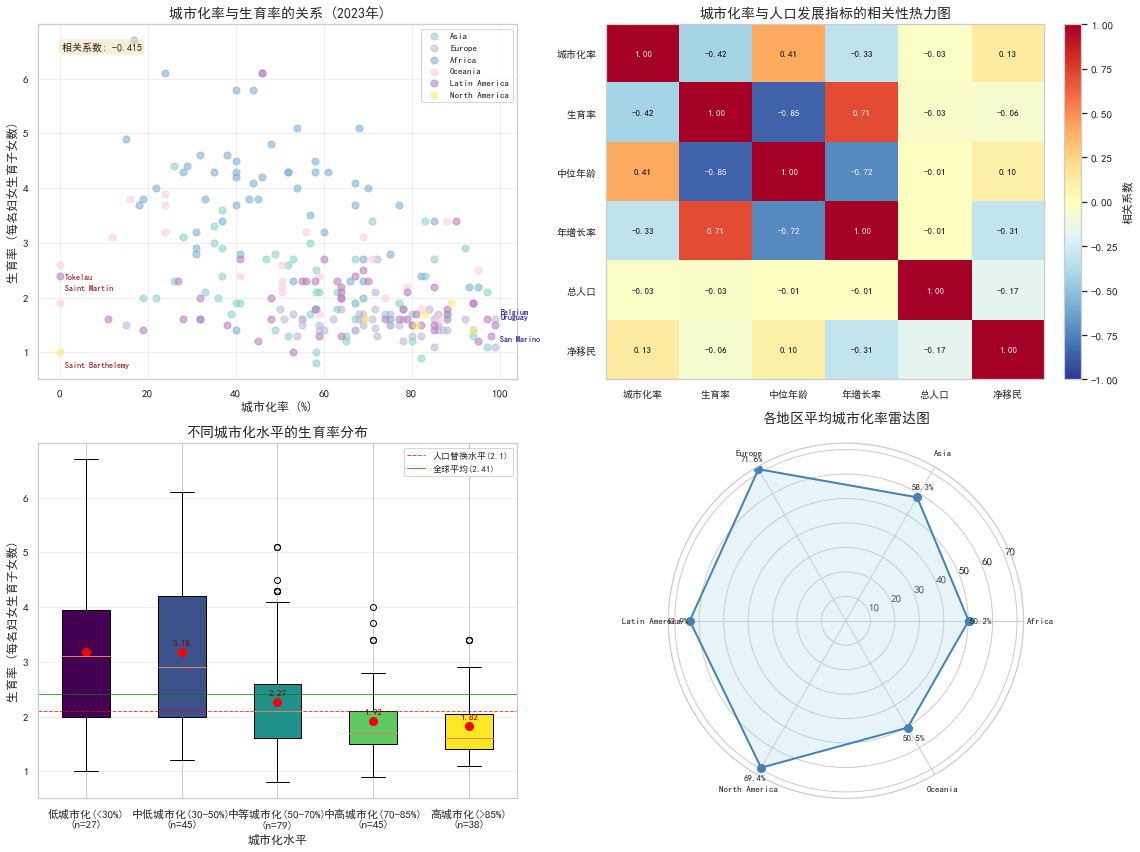

In [30]:
from scipy import stats

print("="*80)
print("第四部分：城市化水平与人口发展的关联分析")
print("="*80)

# 读取数据
print("1. 读取数据...")
df_unified = pd.read_csv('world_data_unified_final.csv')
print(f"统一数据集形状: {df_unified.shape}")

# 城市化率基本统计
print("\n城市化率基本统计信息:")
print(f"  全球平均城市化率: {df_analysis['population_urban'].mean():.1f}%")
print(f"  城市化率中位数: {df_analysis['population_urban'].median():.1f}%")
print(f"  城市化率标准差: {df_analysis['population_urban'].std():.1f}%")
print(f"  城市化率范围: [{df_analysis['population_urban'].min():.1f}%, {df_analysis['population_urban'].max():.1f}%]")

# 定义城市化水平分类
def categorize_urbanization(urban_rate):
    if urban_rate < 30:
        return "低城市化(<30%)"
    elif urban_rate < 50:
        return "中低城市化(30-50%)"
    elif urban_rate < 70:
        return "中等城市化(50-70%)"
    elif urban_rate < 85:
        return "中高城市化(70-85%)"
    else:
        return "高城市化(>85%)"

df_analysis['urban_category'] = df_analysis['population_urban'].apply(categorize_urbanization)

print("\n城市化水平分布:")
urban_counts = df_analysis['urban_category'].value_counts().sort_index()
for category, count in urban_counts.items():
    percentage = count / len(df_analysis) * 100
    print(f"  {category}: {count}个国家 ({percentage:.1f}%)")

print("\n" + "-"*40)
print("2. 城市化与人口发展指标的相关性分析")
print("-"*40)

# 选择用于相关性分析的变量
correlation_vars = ['population_urban', 'fertility_rate', 'median_age', 
                    'yearly_change', 'population', 'net_migrants']
correlation_df = df_analysis[correlation_vars].dropna()

# 计算相关性矩阵
correlation_matrix = correlation_df.corr()
print("\n城市化率与各人口指标的相关性矩阵:")
print(correlation_matrix.round(3))

# 提取城市化率与其他变量的相关性
urban_correlations = correlation_matrix['population_urban'].drop('population_urban')
print("\n城市化率与各指标的相关系数:")
for var, corr in urban_correlations.items():
    var_names = {
        'fertility_rate': '生育率',
        'median_age': '中位年龄',
        'yearly_change': '年增长率',
        'population': '总人口',
        'net_migrants': '净移民'
    }
    print(f"  城市化率 vs {var_names.get(var, var)}: {corr:.3f}")

print("\n" + "-"*40)
print("3. 不同城市化水平的人口特征对比")
print("-"*40)

# 按城市化水平分组统计
urban_stats = df_analysis.groupby('urban_category').agg({
    'fertility_rate': ['mean', 'median', 'std', 'count'],
    'median_age': ['mean', 'median'],
    'yearly_change': ['mean', 'median'],
    'population_urban': ['mean', 'median']
}).round(2)

# 重命名列
urban_stats.columns = ['_'.join(col).strip() for col in urban_stats.columns.values]
urban_stats = urban_stats.rename(columns={
    'fertility_rate_mean': '平均生育率',
    'fertility_rate_median': '生育率中位数',
    'fertility_rate_std': '生育率标准差',
    'fertility_rate_count': '国家数量',
    'median_age_mean': '平均中位年龄',
    'median_age_median': '中位年龄中位数',
    'yearly_change_mean': '平均增长率',
    'yearly_change_median': '增长率中位数',
    'population_urban_mean': '平均城市化率',
    'population_urban_median': '城市化率中位数'
})

print("不同城市化水平的人口特征:")
print(urban_stats[['国家数量', '平均城市化率', '平均生育率', '平均中位年龄', '平均增长率']])

print("\n" + "-"*40)
print("4. 各地区城市化水平对比分析")
print("-"*40)

# 按地区分组统计城市化率
region_urban_stats = df_analysis.groupby('region').agg({
    'population_urban': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'fertility_rate': ['mean'],
    'median_age': ['mean']
}).round(2)

# 重命名列
region_urban_stats.columns = ['_'.join(col).strip() for col in region_urban_stats.columns.values]
region_urban_stats = region_urban_stats.rename(columns={
    'population_urban_mean': '平均城市化率',
    'population_urban_median': '城市化率中位数',
    'population_urban_std': '城市化率标准差',
    'population_urban_min': '最低城市化率',
    'population_urban_max': '最高城市化率',
    'population_urban_count': '国家数量',
    'fertility_rate_mean': '平均生育率',
    'median_age_mean': '平均中位年龄'
})

print("各地区城市化水平统计:")
print(region_urban_stats[['国家数量', '平均城市化率', '城市化率标准差', '平均生育率', '平均中位年龄']])

# 创建可视化图表
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 子图1：城市化 vs 生育率（保留原散点图，无回归线）
ax1 = axes[0, 0]
regions = df_analysis['region'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(regions)))
region_colors = {region: colors[i] for i, region in enumerate(regions)}

for region in regions:
    region_data = df_analysis[df_analysis['region'] == region]
    ax1.scatter(region_data['population_urban'], region_data['fertility_rate'], 
                alpha=0.6, s=50, label=region, color=region_colors[region])

ax1.set_xlabel('城市化率 (%)', fontsize=12)
ax1.set_ylabel('生育率 (每名妇女生育子女数)', fontsize=12)
ax1.set_title('城市化率与生育率的关系 (2023年)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# 计算并添加相关性注释
correlation_urban_fertility = df_analysis[['population_urban', 'fertility_rate']].corr().iloc[0, 1]
ax1.text(0.05, 0.95, f'相关系数: {correlation_urban_fertility:.3f}', 
         transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 标记极端值
if len(df_analysis) > 0:
    # 标记城市化率最高的3个国家
    top_urban = df_analysis.nlargest(3, 'population_urban')
    for idx, row in top_urban.iterrows():
        ax1.annotate(row['country'], (row['population_urban'], row['fertility_rate']), 
                     xytext=(5, 5), textcoords='offset points', fontsize=8, color='darkblue')
    
    # 标记城市化率最低的3个国家
    bottom_urban = df_analysis.nsmallest(3, 'population_urban')
    for idx, row in bottom_urban.iterrows():
        ax1.annotate(row['country'], (row['population_urban'], row['fertility_rate']), 
                     xytext=(5, -15), textcoords='offset points', fontsize=8, color='darkred')

# 子图2：城市化与人口指标的热力图
ax2 = axes[0, 1]

# 使用相关系数矩阵创建热力图
cax = ax2.imshow(correlation_matrix.values, cmap='RdYlBu_r', vmin=-1, vmax=1, aspect='auto')

# 设置坐标轴标签
variables_display = ['城市化率', '生育率', '中位年龄', '年增长率', '总人口', '净移民']
ax2.set_xticks(np.arange(len(variables_display)))
ax2.set_yticks(np.arange(len(variables_display)))
ax2.set_xticklabels(variables_display, fontsize=10)
ax2.set_yticklabels(variables_display, fontsize=10)

# 添加相关系数值
for i in range(len(variables_display)):
    for j in range(len(variables_display)):
        text_color = 'white' if abs(correlation_matrix.iloc[i, j]) > 0.7 else 'black'
        ax2.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                 ha='center', va='center', color=text_color, fontsize=9)

# 添加颜色条
cbar = plt.colorbar(cax, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('相关系数', fontsize=11)

ax2.set_title('城市化率与人口发展指标的相关性热力图', fontsize=14, fontweight='bold')
ax2.grid(False)

# 子图3：不同城市化水平的生育率箱线图（保留原箱线图）
ax3 = axes[1, 0]

# 按城市化分类排序
urban_categories_sorted = ['低城市化(<30%)', '中低城市化(30-50%)', '中等城市化(50-70%)', '中高城市化(70-85%)', '高城市化(>85%)']
urban_data = []
urban_labels = []

for category in urban_categories_sorted:
    if category in df_analysis['urban_category'].unique():
        category_fertility = df_analysis[df_analysis['urban_category'] == category]['fertility_rate'].dropna()
        if len(category_fertility) > 0:
            urban_data.append(category_fertility)
            urban_labels.append(f"{category}\n(n={len(category_fertility)})")

boxplot_urban = ax3.boxplot(urban_data, labels=urban_labels, patch_artist=True)

# 设置箱线图颜色
colors_urban = plt.cm.viridis(np.linspace(0, 1, len(urban_data)))
for patch, color in zip(boxplot_urban['boxes'], colors_urban):
    patch.set_facecolor(color)

# 添加平均值点
for i, category in enumerate(urban_categories_sorted, 1):
    if category in df_analysis['urban_category'].unique():
        category_mean = df_analysis[df_analysis['urban_category'] == category]['fertility_rate'].mean()
        ax3.plot(i, category_mean, 'o', color='red', markersize=8)
        ax3.text(i, category_mean+0.1, f'{category_mean:.2f}', ha='center', va='bottom', fontsize=9, color='darkred')

# 添加人口替换水平线
ax3.axhline(y=2.1, color='red', linestyle='--', linewidth=1, alpha=0.7, label='人口替换水平(2.1)')
ax3.axhline(y=df_analysis['fertility_rate'].mean(), color='green', linestyle='-', linewidth=1, alpha=0.7, 
            label=f'全球平均({df_analysis["fertility_rate"].mean():.2f})')

ax3.set_xlabel('城市化水平', fontsize=12)
ax3.set_ylabel('生育率 (每名妇女生育子女数)', fontsize=12)
ax3.set_title('不同城市化水平的生育率分布', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

# 子图4：各地区城市化率雷达图
ax4 = axes[1, 1]

# 创建极坐标子图
ax4 = plt.subplot(2, 2, 4, projection='polar')

# 准备雷达图数据
regions_radar = region_urban_stats.index.tolist()
urban_rates = region_urban_stats['平均城市化率'].tolist()

# 闭合数据
regions_radar.append(regions_radar[0])
urban_rates.append(urban_rates[0])

# 计算角度
theta = np.linspace(0, 2*np.pi, len(regions_radar), endpoint=True)

# 绘制雷达图
ax4.plot(theta, urban_rates, marker='o', linewidth=2, markersize=8, color='steelblue')
ax4.fill(theta, urban_rates, alpha=0.3, color='lightblue')

# 设置标签
ax4.set_xticks(theta[:-1])
ax4.set_xticklabels(regions_radar[:-1], fontsize=9)
ax4.set_title('各地区平均城市化率雷达图', fontsize=14, fontweight='bold', pad=20)
ax4.grid(True)

# 添加数值标签
for i, (angle, rate) in enumerate(zip(theta[:-1], urban_rates[:-1])):
    ax4.text(angle, rate + 5, f'{rate:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold')

# 调整布局，给雷达图更多空间
plt.tight_layout()

plt.savefig('urbanization_analysis_new.png', dpi=300, bbox_inches='tight')
print("\n图表已保存为 'urbanization_analysis_new.png'")

print("\n" + "-"*40)
print("5. 城市化发展模式分析")
print("-"*40)

# 分析城市化与发展的关系
print("城市化发展模式分类:")
print("-"*40)

# 定义发展模式
def categorize_development(row):
    if row['population_urban'] > 75 and row['fertility_rate'] < 1.8 and row['median_age'] > 35:
        return "高度城市化成熟型"
    elif row['population_urban'] > 60 and row['fertility_rate'] < 2.5 and row['median_age'] > 30:
        return "快速城市化转型型"
    elif row['population_urban'] < 50 and row['fertility_rate'] > 3.0 and row['median_age'] < 25:
        return "低城市化高增长型"
    elif row['population_urban'] < 40 and row['fertility_rate'] > 4.0 and row['median_age'] < 20:
        return "农业社会高生育型"
    else:
        return "过渡型/其他"

df_analysis['development_pattern'] = df_analysis.apply(categorize_development, axis=1)

# 统计各发展模式的数量
pattern_counts = df_analysis['development_pattern'].value_counts()
print("城市化发展模式分布:")
for pattern, count in pattern_counts.items():
    percentage = count / len(df_analysis) * 100
    print(f"  {pattern}: {count}个国家 ({percentage:.1f}%)")

# 分析各发展模式的特征
pattern_stats = df_analysis.groupby('development_pattern').agg({
    'population_urban': ['mean', 'count'],
    'fertility_rate': ['mean'],
    'median_age': ['mean'],
    'yearly_change': ['mean']
}).round(2)

pattern_stats.columns = ['_'.join(col).strip() for col in pattern_stats.columns.values]
pattern_stats = pattern_stats.rename(columns={
    'population_urban_mean': '平均城市化率',
    'population_urban_count': '国家数量',
    'fertility_rate_mean': '平均生育率',
    'median_age_mean': '平均中位年龄',
    'yearly_change_mean': '平均增长率'
})

print("\n不同发展模式的特征:")
print(pattern_stats)

# 保存详细分析结果
df_analysis.to_csv('urbanization_analysis_detailed.csv', index=False, encoding='utf-8-sig')
print("\n详细分析结果已保存为 'urbanization_analysis_detailed.csv'")

print("\n" + "="*80)
print("城市化水平与人口发展的关联分析完成！")
print("="*80)

# 输出主要发现总结
print("\n主要发现总结:")
print("-"*40)
print("1. 城市化与人口结构的核心关系:")
print(f"   - 城市化率与生育率呈负相关 (r={correlation_urban_fertility:.3f})")
print(f"   - 城市化率与中位年龄呈正相关 (r={correlation_matrix.loc['population_urban', 'median_age']:.3f})")

print(f"\n2. 全球城市化水平特征:")
print(f"   - 全球平均城市化率: {df_analysis['population_urban'].mean():.1f}%")
high_urban_count = len(df_analysis[df_analysis['population_urban'] > 70])
print(f"   - 城市化率超过70%的国家: {high_urban_count}个 ({high_urban_count/len(df_analysis)*100:.1f}%)")
low_urban_count = len(df_analysis[df_analysis['population_urban'] < 40])
print(f"   - 城市化率低于40%的国家: {low_urban_count}个 ({low_urban_count/len(df_analysis)*100:.1f}%)")

print(f"\n3. 地区城市化差异:")
print(f"   - 城市化率最高的地区: {region_urban_stats['平均城市化率'].idxmax()} ({region_urban_stats['平均城市化率'].max():.1f}%)")
print(f"   - 城市化率最低的地区: {region_urban_stats['平均城市化率'].idxmin()} ({region_urban_stats['平均城市化率'].min():.1f}%)")

print("\n4. 不同城市化水平的人口特征:")
for category in urban_categories_sorted:
    if category in urban_stats.index:
        stats = urban_stats.loc[category]
        print(f"   {category}:")
        print(f"     - 平均生育率: {stats['平均生育率']:.2f}")
        print(f"     - 平均中位年龄: {stats['平均中位年龄']:.1f}岁")
        print(f"     - 平均增长率: {stats['平均增长率']:.2f}%")

print("\n5. 城市化发展模式:")
for pattern in pattern_counts.index[:4]:  # 显示前4种模式
    stats = pattern_stats.loc[pattern]
    print(f"   {pattern}: {int(stats['国家数量'])}个国家")
    print(f"     - 平均城市化率: {stats['平均城市化率']:.1f}%")
    print(f"     - 平均生育率: {stats['平均生育率']:.2f}")
    print(f"     - 平均中位年龄: {stats['平均中位年龄']:.1f}岁")

print("\n6. 政策启示:")
print("   - 高度城市化国家需关注低生育率和老龄化问题")
print("   - 低城市化国家面临高生育率和快速城市化的双重挑战")
print("   - 城市化进程与人口转型存在密切关联")
print("   - 需制定差异化的区域城市化发展策略")

# 显示图表
plt.show()